In [1]:
# Import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


# Please note these are for testing only!
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import rbf_kernel

# Set the plot size for this note book for easy readability
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [2]:
def get_data(path):
    '''
    --------------------------
    Input: File path to data
    Output: Dataframe with assigment data
    -------------------------
    '''
    df = pd.read_csv(path)
    return(df)

In [3]:
def train_test_split(df, train_percent=0.666666):
    '''
    --------------------------
    Split data into train and test sets
    Input: Dataframe containing assignment data
    Output: Training dataframe and testing dataframe
    split according to specified percentage
    -------------------------
    '''
    # Shuffle dataset
    df = df.sample(frac=1).reset_index(drop=True)
    
    # Calculate no. of training examples based on train_percent
    # Here we use 2/3, 1/3 by default as required by the assignment
    n_train = round(train_percent*len(df))
    
    # Filter the dataframe to get training and testing rows
    df_train = df[:n_train]
    df_test = df[n_train:]
    
    return(df_train, df_test)

In [4]:
def get_grid_search_vals(start_g, stop_g, start_s, stop_s):
    '''
    --------------------------
    Input: 1) start_g: starting exponent for gamma
           2) stop_g: ending exponent for gamma
           3) start_s: starting exponent for sigma
           4) stop_s: ending exponent for sigma  
    Output: Two lists of gamma and sigma values
    that will be searched over for 'good' model
    parameters
    -------------------------
    '''
    gamma_powers = np.arange(start_g, stop_g + 1, 1)
    sigma_powers = np.arange(start_s, stop_s + 0.5, 0.5)
    
    print(gamma_powers)
    print(sigma_powers)
    
    gamma = np.power(0.5, gamma_powers)
    sigma = np.power(2, sigma_powers)
    
    return(gamma, sigma)

In [5]:
def get_pairwise_dist(A, B):
    '''
    --------------------------
    Load data from source
    Input: A: An array of x-values np.array
           B: Another array of x-values np.array
    Output: Pairwise Euclidean distances between A and B
    
    The output from this function is used 
    to calculate the Gaussian kernel. We used
    einsum here because we read that it can 
    provide a speed advantage in these 
    situations.
    
    References for einsum:
    https://ajcr.net/Basic-guide-to-einsum/
    -------------------------
    '''
    # 1) Element wise product and then sum horizontally
    # 1) Element wise product and then sum horizontally
    # 2) Dot product between A and B.T
    dist = np.einsum('ij,ij->i',A, A)[:,None] + np.einsum('ij,ij->i',B,B) - 2*np.dot(A,B.T)
    return(dist)

In [6]:
def get_gaussian_kernel(X, X_test, sigma):
    '''
    --------------------------
    Input: X: Training matrix
           X_test: Testing matrix
           sigma: Parameter for Kernel
    Output: Gaussian kernel matrix K(X, X_test)
    
    This function computes the 
    Gaussian kernel matrix for X and X_test.
    It calls the pairwise distance function above
    to first create the matrix of distances. Then 
    It scales and exponentiates them to recover 
    the kernel values.
    -------------------------
    '''
    scale = -0.5/np.power(sigma, 2)
    K = get_pairwise_dist(X, X_test) 
    K = K*scale
    K = np.exp(K)
    return(K)

In [7]:
def get_kernel_ridge_coeff(X, Y, sigma, gamma):
    '''
    --------------------------
    Input: X: Feature values from training data
           Y: Feature labels 
           sigma: parameter for Gaussian kernel
           gamma: regularization parameter
    Output: Analytical dual ridge regression coefficients
            [alpha]
    -------------------------
    '''
    # Store the no. of examples
    m = Y.shape[0]
    # Get the Kernel matrix for the training data
    K = get_gaussian_kernel(X, X, sigma)
    # Solve for the coefficients in the dual form using the analytical formula
    alpha = np.linalg.solve(K + gamma*np.identity(m), Y)
    # Reshape to add a column so alpha conforms to the test matrices later
    alpha = alpha.reshape(alpha.shape[0], 1)
    
    return(alpha)

In [8]:
def get_kernel_ridge_prediction(alpha, X, X_test, sigma):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    # Get Gaussian kernel between K and K test
    K_test = get_gaussian_kernel(X, X_test, sigma)
    # Multiply element wise and then sum downwards to get # test points columns
    y_pred = np.einsum('ij,ij->j', alpha, K_test)
    return(y_pred)

In [9]:
def get_k_folds(df_train, k = 5):
    '''
    --------------------------
    Load data from source
    Input: df_train: Training dataframe
           k: no. of folds to divide this into
    Output: List of data frames where each
            dataframe is a fold
    -------------------------
    '''
    fold_size = round(len(df_train)/k)
    df_train = df_train.sample(frac=1).reset_index(drop=True)
    df_folds = [df_train.iloc[i:i+fold_size] for i in range(0,len(df_train)-fold_size+1,fold_size)]
    return(df_folds)

In [10]:
def get_mse(Y, Y_hat):
    '''
    ------------------------
    Input: Y: Labels and 
           Y_hat: predicted values
    Output: Mean squared error
    ------------------------
    '''
    return np.sum(np.power(Y-Y_hat, 2))/max(Y.shape)

In [11]:
def plot_3d_mse(history, 
                k=5, 
                path = '1_3_cv_error.png',
                title = 'Cross Validation Error by Parameter Settings',
                log = False):
    '''
    --------------------------
    Input: history: dictionary containing
                    record of results from kernel
                    ridge training
            k: no. of folds [to use in plot labels]
            path: destination for generated plots
            title: plot annotation
            log: whether to plot on log scale or not
            
    Output: Plot of k-fold cross-validation MSE by
            parameter value after grid search
    -------------------------
    '''
    # Store the data
    x = np.array(history['gamma'])
    y = np.array(history['sigma'])
    z = np.array(history['mse_val'])
    ln_z = np.log(z)
    
    # Make the plot
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    # Make the plot
    if log: 
        ax.scatter3D(x, y, ln_z, c=ln_z, cmap='jet_r');
    else: 
        ax.scatter3D(x, y, z, c=z, cmap = 'jet_r')
    ax.set_title(title)
    
    # Set the z-axis label
    if log: 
        z_label = r'Log Mean MSE over {} folds'.format(k)
    else: 
        z_label = r'Mean MSE over {} folds'.format(k)
    
    # Set labels
    ax.set_xlabel(r'$\gamma$')
    ax.set_ylabel(r'$\sigma$')
    ax.set_zlabel(z_label)
    
    # Save and then display
    path = os.path.join('.', '..', 'figs', path)
    plt.savefig(path)
    plt.show()

In [12]:
def train_kernel_ridge(X_train, X_val, Y_train, Y_val, sigma, gamma):
    '''
    --------------------------
    Input: X_train: Training features
           X_val: Validation features
           Y_train: Training labels
           Y_val: Validation labels
           sigma: Parameter for Gaussian
           gamma: Regularization parameter
    Output: Results from kernel ridge training
            alpha: coefficients
            Y_pred_train: predictions on training set
            y_pred_val: predictions on test set
            mse_train: MSE on training set
            mse_val: MSE on validation set
    -------------------------
    '''
    # Get dual form estimates
    alpha = get_kernel_ridge_coeff(X_train, Y_train, sigma, gamma)

    # Get predictions
    y_pred_train = get_kernel_ridge_prediction(alpha, X_train, X_train, sigma)
    y_pred_val = get_kernel_ridge_prediction(alpha, X_train, X_val, sigma)
    
    # Get loss values
    mse_train = get_mse(Y_train, y_pred_train)
    mse_val = get_mse(Y_val, y_pred_val)
    
    # Return statement
    return(alpha, y_pred_train, y_pred_val, mse_train, mse_val)

In [13]:
def get_best_params(history):
    '''
    --------------------------
    Input: history: dictionary containing
                    record of kernel ridge
                    grid search
    Output: 
    -------------------------
    '''
    best_run = np.array(history['mse_val']).argmin()
    best_val_mse = np.array(history['mse_val']).min()
    
    best_gamma, best_sigma = history['gamma'][best_run], history['sigma'][best_run]
    best_alpha = history['alpha'][best_run]
    
    best_params = {'best_run': best_run, 
                   'best_gamma': best_gamma, 
                   'best_sigma': best_sigma, 
                   'best_val_mse': best_val_mse, 
                   'best_run_alpha': best_alpha}
    
    return(best_params)

In [14]:
def test_pairwise_dist(A, B):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    
    References for einsum:
    https://ajcr.net/Basic-guide-to-einsum/
    -------------------------
    '''
    dist = get_pairwise_dist(A, B)
    dist_sk = cdist(A, B)**2
    return(dist, dist_sk, np.allclose(dist, dist_sk))


def test_gaussian_kernel(X, X_test, sigma):

    kernel = get_gaussian_kernel(X, X_test, sigma)
    kernel_sk = rbf_kernel(X, X_test, 0.5)
    return(np.allclose(kernel, kernel_sk))

def test_kernel_ridge_coeff():

    a = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape(2,4)
    b = np.array([2, 4]).reshape(2,1)
    result = get_kernel_ridge_coeff(K, b, 1, 2)
    return(result)

def test_kernel_ridge_prediction():

    a = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape(2,4)
    b = np.array([5, 8, 9, 10, 11, 12, 13, 14, 18, 19, 20, 21, 25, 26, 7, 8]).reshape(4,4)
    
    alpha = test_kernel_ridge_coeff()
    result = get_kernel_ridge_prediction(alpha, a, b, 1)
    
    return(result)


def tests():

    # Make test data
    a = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape(2,4)
    b = np.array([2, 4, 6, 8, 10, 12, 14, 16]).reshape(2,4)
    
    dist_test_result = test_pairwise_dist(a, b)
    kern_test_result = test_gaussian_kernel(a, b, 1)
    
    coeff_test_result = test_kernel_ridge_coeff()
    prediction_test_result = test_kernel_ridge_prediction()
    
    return(dist_test_result, kern_test_result)

In [15]:
def main(k=5, mode='single'):
    '''
    --------------------------
    Inputs: k: No. of folds
            mode: run for single run
                  or multiple runs
    
    This is the main training loop
    for kernel ridge regression. 
    We set parameters here and
    do a grid search over the 
    values specified in the question
    using k-fold cross-validation. 
    We return the best parameter
    values and the associated error 
    metrics. As a side effect
    we make CV error plots across
    the search space.
    -------------------------
    '''
    # Setup
    path = 'http://www0.cs.ucl.ac.uk/staff/M.Herbster/boston-filter/Boston-filtered.csv'
    
    # Set parameters for grid search
    start_g = 26
    stop_g = 40
    start_s = 7
    stop_s = 13
    
    # Get list of parameters to search over
    gamma_list, sigma_list = get_grid_search_vals(start_g, stop_g, start_s, stop_s)
    
    # Load data
    df = get_data(path)
    
    # Split into train and test: we are making 2/3 splits as required by default
    df_train, df_test = train_test_split(df)

    # Divide training data into k=5 folds for cross-validation as question asks
    df_folds = get_k_folds(df_train, k)
    
    # Convert data-frames into numpy arrays
    X_folds = [df_fold.iloc[:,:12].to_numpy() for df_fold in df_folds]
    Y_folds = [df_fold['MEDV'].to_numpy() for df_fold in df_folds]
    
    # Create a container to store results
    history = {'gamma': [],
               'sigma': [],
               'mse_val': [],
               'mse_train': [], 
               'pred_train': [],
               'pred_val': [],
               'alpha': []}
    
    counter = 0
    
    # This loop iterates over the grid
    for sigma in sigma_list:
        for gamma in gamma_list:
            
            # Record the parameter values
            history['sigma'].append(sigma)
            history['gamma'].append(gamma)
            
            # Print progress check
            counter += 1
            print(counter)
            
            # Make containers for train and validation MSE by fold
            mse_train_by_fold = []
            mse_val_by_fold = []
    
            # Now train for each fold
            for i in range(k):
        
                # Stack data matrices
                X_train_fold = np.vstack(X_folds[0:i] + X_folds[i+1:])
                Y_train_fold = np.hstack(Y_folds[0:i] + Y_folds[i+1:])
            
                # Get the ith fold and take it as the validation labels
                # The rest of the data are stacked and put in a container
                X_val_fold = X_folds[i]
                Y_val_fold = Y_folds[i]
        
                # Train the ridge regression
                alpha, y_pred_train, y_pred_val, mse_train, mse_val = train_kernel_ridge(X_train_fold, 
                                                                                         X_val_fold, Y_train_fold, 
                                                                                         Y_val_fold, sigma, gamma)
                
                # Store the result
                mse_train_by_fold.append(mse_train)
                mse_val_by_fold.append(mse_val)
                
            print(mse_train_by_fold)
            print(mse_val_by_fold)
            
            history['alpha'].append(alpha)
            history['pred_train'].append(y_pred_train)
            history['pred_val'].append(y_pred_val)
            history['mse_val'].append(np.mean(np.array(mse_val_by_fold)))
            history['mse_train'].append(np.mean(np.array(mse_train_by_fold)))
    
    # Store best parameters
    best_params = get_best_params(history)
    best_gamma = best_params['best_gamma']
    best_sigma = best_params['best_sigma']
    
    print("The best gamma value is: {}".format(best_gamma))
    print("The best sigma value is: {}".format(best_sigma))
    
    # Make plot
    if mode =='single':
        plot_3d_mse(history)
        plot_3d_mse(history, log=True, path='1_3_log_cv_error.png')
    
    # Now store full train and test sets for training with best parameters
    X_train = df_train.iloc[:,:12].to_numpy()
    Y_train = df_train['MEDV'].to_numpy()
    
    X_test = df_test.iloc[:,:12].to_numpy()
    Y_test = df_test['MEDV'].to_numpy()
    
    # Now retrain on the full data-set with best model
    alpha, y_pred_train, y_pred_val, best_param_mse_train, best_param_mse_test = train_kernel_ridge(X_train, X_test, Y_train, 
                                                                                 Y_test, best_sigma, best_gamma)
    
    
    return(history, best_params, best_param_mse_train, best_param_mse_test)

In [16]:
def execute_many(n_runs=20, mode = 'many'):
    
    history = {'gamma': [],
               'sigma': [],
               'mse_train': [],
               'mse_test': []}
    
    for n_run in range(n_runs):
        print("This is run {}".format(n_run))
        _, best_params, best_param_mse_train, best_param_mse_test = main(mode='many')
        history['gamma'].append(best_params['best_gamma'])
        history['sigma'].append(best_params['best_sigma'])
        history['mse_train'].append(best_param_mse_train)
        history['mse_test'].append(best_param_mse_test)
        
    avg_mse_train = np.mean(np.array(history['mse_train']))
    avg_mse_test = np.mean(np.array(history['mse_test']))
    std_mse_train = np.std(np.array(history['mse_train']))
    std_mse_test = np.std(np.array(history['mse_test']))
    
    return(avg_mse_train, avg_mse_test, std_mse_train, std_mse_test)

[26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
[ 7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13. ]
1
[1.1991008700406747, 2.0970554036469284, 1.5439065137871697, 1.7919774733435578, 1.1439219922142196]
[53.40280698398753, 75.9317807517602, 5702.762555862329, 276.2812225665872, 165.62084746937416]
2
[1.0324665314922834, 1.7782015940219167, 1.2668616658133578, 1.4814674048011596, 0.9107721998205953]
[60.256787074879085, 80.37666337149089, 9974.48315800749, 410.6629332565991, 216.13367476028634]
3
[0.868492726638042, 1.4630764232430349, 1.019497747633562, 1.198688985635621, 0.698719235764513]
[66.68765666724696, 83.16864067569593, 15566.514865827054, 575.3304635260439, 269.9716581734507]
4
[0.7093971089519611, 1.179700296856474, 0.8095695737362638, 0.9568506545573343, 0.5285492597277989]
[76.44503277521508, 89.49103453398389, 22228.954506468966, 782.2769546396578, 325.4523982421513]
5
[0.5588201073977986, 0.9343012005045156, 0.6307534678529153, 0.7577462445529456, 0.4122363

[3.7123098417182616, 4.885821131905835, 4.2297277719524216, 4.8139941538660045, 3.8319706892161283]
[17.489601888952667, 10.007917700061922, 161.56975214629148, 27.013250933311628, 17.68677916786189]
47
[3.2079160725877514, 4.436376222877063, 3.729687652134701, 4.3262088452325544, 3.404666760313436]
[19.16415202096148, 9.938115813102854, 389.49621779904567, 35.80975243792436, 19.26312775557126]
48
[2.7844093494570092, 4.030356966130342, 3.3027705179302824, 3.8776687421487095, 3.03209076273043]
[20.423708466294183, 10.136603477627355, 977.051099493539, 51.30379826485408, 22.502238714688463]
49
[2.431693515916989, 3.6786478432443555, 2.959638110161454, 3.4926064402801145, 2.707701523406093]
[21.187418106161278, 10.945956576693625, 2313.713040762323, 74.48733461011025, 28.13607708058723]
50
[2.133410719548984, 3.379972896497259, 2.684796055385408, 3.1683928340663328, 2.4162020711159413]
[22.008487549915046, 12.512894176512752, 4675.162018304455, 106.24484949155092, 36.51878262772235]
51
[

[7.403991990822272, 8.458020108241177, 7.8707933370717695, 7.485148156800962, 7.023721884153415]
[13.528395132016897, 8.486152772304347, 103.1221970187707, 18.007355216040647, 16.3154154773525]
92
[6.9367327731746995, 8.012754366807444, 7.44853429006998, 7.171908973933002, 6.691940060886362]
[13.700699559472826, 8.580731920377277, 122.35944069480922, 18.59925396223162, 16.484386362424022]
93
[6.46817975172774, 7.579261616682943, 7.027598562423097, 6.876428129921518, 6.343881386938635]
[14.188395529171343, 8.745975658876137, 148.13198694734118, 19.19643798993118, 16.65455089684277]
94
[6.018394053845629, 7.158994262587996, 6.6159598500624375, 6.587198891073707, 5.972517821854121]
[14.858571177883592, 8.860511953198175, 156.0037595854552, 19.790248819160734, 16.84484128235662]
95
[5.596765517170605, 6.744832621739895, 6.218498958052288, 6.305048300079452, 5.581895846525261]
[15.609113983489358, 8.933727669015127, 117.87908140688111, 20.09472619737238, 17.069016321854594]
96
[5.1835346301

[9.321288505489367, 10.500579162369991, 9.900242866683987, 9.508139848199212, 8.707015284478507]
[16.663332470725347, 10.267199701585945, 99.14510467863701, 14.908471808918032, 16.309951580676206]
140
[8.913827203495448, 10.076378888394554, 9.386066520107432, 8.90751556540238, 8.245069447663612]
[15.428551835354975, 9.665901776368013, 134.52418819921746, 16.595684860661184, 16.419970999222404]
141
[8.517599388584074, 9.685444620624304, 8.938381284679956, 8.416816317103175, 7.886196950961075]
[14.541261451496004, 9.066922658451684, 169.27594356252214, 18.088578096568256, 16.443946871140568]
142
[8.092418111963294, 9.284115809880534, 8.524625019391761, 7.997690643213934, 7.5770733828885355]
[13.964176919278387, 8.518411329413611, 212.50232504435408, 18.978925409963175, 16.35819860183944]
143
[7.61554747353097, 8.861038122785663, 8.124415167490154, 7.644175502665579, 7.280951717088742]
[13.741640941473264, 8.110666585831533, 277.78417520414365, 19.292665254750098, 16.201243411539707]
144


[18.464692712588697, 21.60208568096398, 20.335931721054276, 21.688857974037987, 20.459734184764308]
[35.36622125144451, 19.46334227935035, 33.456810329506226, 20.990227797363133, 23.398211169790116]
184
[16.934330086815404, 19.559460061667654, 18.791195661220236, 19.755571514465355, 18.494139434079305]
[32.80137517522464, 18.46082483941136, 35.024882504126445, 19.508287054222663, 21.871683097479835]
185
[15.062159033919487, 17.21205959718552, 16.907341893570607, 17.409786024218302, 16.123435303747897]
[29.565959099161937, 16.90764328872711, 33.677778270040825, 17.59678965568872, 20.122614339788957]
186
[13.17431257655983, 14.95408775357044, 14.88112471784297, 15.023874879098937, 13.748342834338793]
[26.077315155233, 15.070736628447227, 28.180036989335587, 15.679892912066217, 18.469781265045363]
187
[11.655862952629105, 13.170653904839726, 13.073693577847303, 13.008463877352144, 11.786869411821534]
[22.883225820271953, 13.356578288863277, 20.45965481131471, 14.224555217305271, 17.264346

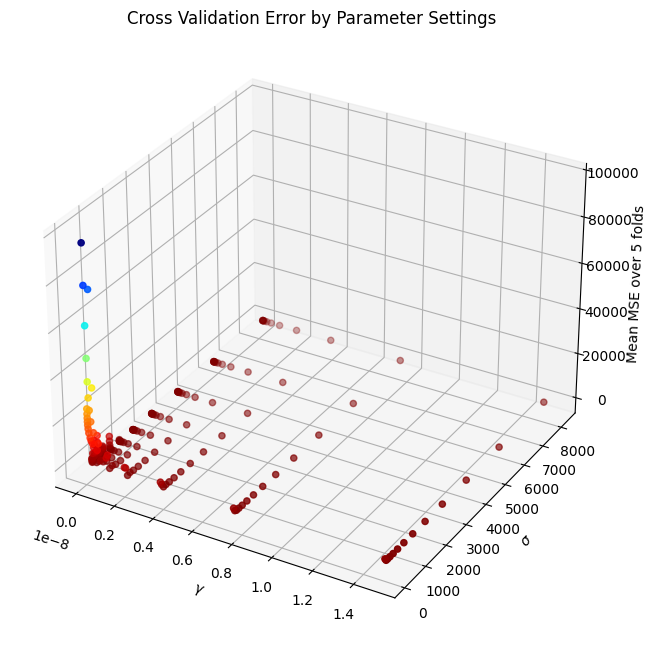

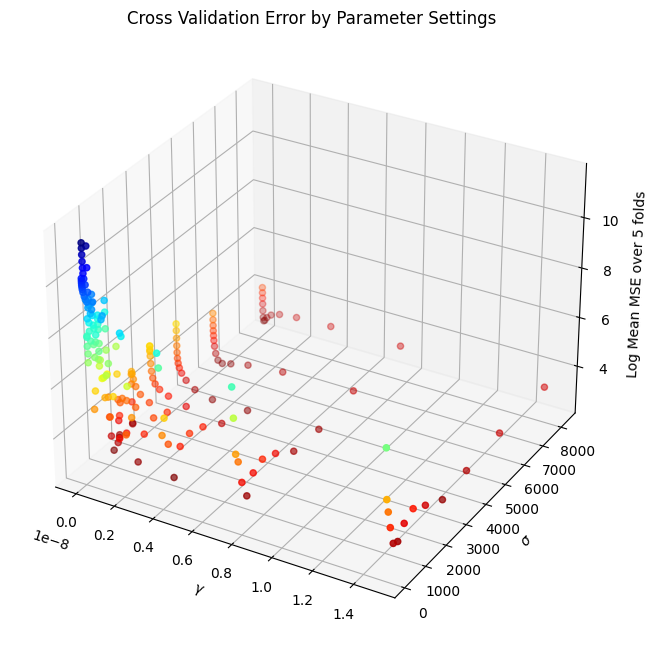

In [17]:
np.random.seed(4109)

history, best_params, best_param_mse_train, best_param_mse_test = main()

In [18]:
# Print results from one run
print(best_params)
print(best_param_mse_train) 
print(best_param_mse_test)

{'best_run': 188, 'best_gamma': 5.820766091346741e-11, 'best_sigma': 8192.0, 'best_val_mse': 14.715026712762969, 'best_run_alpha': array([[ 1.22436340e+10],
       [ 2.29029523e+10],
       [-7.15945720e+10],
       [ 8.91033868e+09],
       [ 1.60508359e+11],
       [ 1.33049923e+10],
       [-3.56150661e+10],
       [-7.40825212e+09],
       [ 9.83317098e+10],
       [ 3.71089301e+09],
       [-2.92899675e+10],
       [ 2.33936198e+11],
       [ 1.85648356e+10],
       [ 4.39550807e+10],
       [ 3.24123983e+10],
       [-2.80790789e+10],
       [-1.52460291e+10],
       [ 5.49077635e+10],
       [ 7.65830566e+10],
       [-4.59645037e+10],
       [ 6.37930233e+10],
       [ 7.29067338e+09],
       [-2.41920008e+10],
       [ 4.44460142e+10],
       [ 6.34188295e+10],
       [-3.57687903e+10],
       [-2.47087531e+10],
       [-8.34992973e+08],
       [-3.28467397e+10],
       [ 1.69761562e+10],
       [ 5.92968836e+10],
       [ 3.27868732e+10],
       [ 2.98528231e+10],
       [-2.

In [19]:
# Print results from many runs
avg_mse_train, avg_mse_test, std_mse_train, std_mse_test = execute_many(mode='many')

This is run 0
[26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
[ 7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13. ]
1
[0.7987614442788298, 1.068184612473041, 1.184186788552603, 1.178638321001634, 1.1465384251576887]
[75.29460065090282, 467.4548639835338, 565.5500607571328, 90.06887802590619, 81.48302951870573]
2
[0.6806522249605368, 0.8795714619429316, 0.9594808642043424, 0.9612796099005012, 0.9286069233954447]
[87.41094665381233, 747.0521537405227, 709.6668622222307, 108.09070544773544, 123.88537204289382]
3
[0.5681444414004541, 0.7081630086804456, 0.7770317743108069, 0.7509493743189849, 0.7495840927520321]
[85.42788296995295, 1014.1634521570355, 756.386945336942, 134.21013445163683, 166.98199255789925]
4
[0.4728805972536126, 0.5513750883105621, 0.6360727544216821, 0.565116502904751, 0.6072868610739985]
[78.8731365247133, 1187.1692162267025, 706.0729326690939, 176.157682601674, 197.78062824716736]
5
[0.4000725110250553, 0.41655397378306397, 0.5262101042779629, 0.4220612491

[0.4685626880578008, 0.46002499029759575, 0.5717866022750546, 0.48710114998004594, 0.5608079308271645]
[128.96923224567664, 3367.6786909031766, 852.3410163429536, 344.3243049306643, 207.2109649019349]
42
[0.4016258780668585, 0.3407252578299346, 0.4641448780351437, 0.36128967381732774, 0.46258481663100265]
[103.95426352803453, 4888.383728935641, 1424.0821447721069, 495.8841817660738, 231.204054839049]
43
[0.34735619286936237, 0.2539777322504085, 0.381151197409463, 0.2733894402072555, 0.38047773798963275]
[173.33092915169092, 6138.9169511311275, 2187.186276035247, 664.0308288151942, 272.7067653419099]
44
[0.2970376317776463, 0.19492364220650757, 0.3150782194808893, 0.2096275415599219, 0.31713905933889347]
[595.9327018876559, 7202.235089032666, 3035.147169069587, 830.1934004980761, 330.48949448034705]
45
[0.24435003697646596, 0.15352969098443123, 0.2541295047201356, 0.16022041596864856, 0.2660928082239557]
[1890.0306729872198, 8172.873898627141, 3895.8108342267406, 1011.2207849331169, 390

[1.168662854121548, 1.4780007439589045, 1.5104102849048466, 1.5314201703847998, 1.4737019518449723]
[142.28470362731338, 59.18059017064396, 53.51150839952169, 57.7044220551095, 45.62039696219446]
90
[1.0586686447326248, 1.3203538641528187, 1.3834588053488908, 1.392898362884576, 1.3309597744521644]
[183.35212393211586, 83.49405394481244, 54.52493355458353, 69.17215408951768, 59.63054755200925]
91
[6.236841644287635, 7.467214331730086, 7.6656420081981125, 7.3610180056087895, 7.695876381849049]
[15.060877161617224, 14.55941545969061, 10.110407414742648, 13.834549056649495, 9.54166056304289]
92
[5.735752594432468, 7.141497818733105, 7.278970234588752, 6.981831034625633, 7.296691623220871]
[15.609315813958116, 14.786388934490097, 10.280105109081806, 14.058605016865227, 9.364319508970445]
93
[5.239263441206479, 6.801891625779332, 6.879659026231338, 6.5676288202804525, 6.894178710057493]
[16.29757525503799, 14.532756019589398, 10.507431011446316, 14.512400050874675, 9.183314296782921]
94
[4.7

[3.309747600084476, 4.608843042679242, 4.729079210172171, 4.356760172994057, 4.872823933506967]
[23.84932912378169, 25.037054756809745, 11.812637473137967, 21.93422291873329, 8.169642529287444]
134
[3.0327536707204663, 4.0825975397184715, 4.156596828372176, 3.926786666472456, 4.401598572762155]
[24.22839729193431, 29.578936179891894, 12.600603642632711, 23.5468269518685, 7.7856066008290234]
135
[2.736301410180419, 3.57555296298728, 3.5689218432244965, 3.489405847093952, 3.916922707619952]
[24.65157439623306, 31.62320495778056, 14.387271411490085, 24.671991477546406, 7.220060290436246]
136
[10.822527479952553, 11.869176892431168, 11.853666930512773, 11.467109297197924, 12.037713768627789]
[18.10870539586545, 13.952026029048053, 12.624750414827975, 17.290635523849716, 13.020781800016117]
137
[9.584544322263335, 10.591245024115446, 10.546386493064837, 10.230065605944644, 10.841812711594365]
[16.637083959776046, 12.704915643889597, 11.670718443804454, 15.542056971488272, 11.621185537248593

[7.183688492291196, 7.883489781745871, 8.166394586063463, 7.8316653729666985, 8.565839958187306]
[14.10369186277807, 15.715305485578163, 10.732115588124229, 14.240039728314047, 8.82665207470364]
177
[6.848127259963484, 7.594433699528958, 7.902453838565261, 7.5447920806343145, 8.253655410305555]
[14.127684949435185, 16.611239506500123, 10.753626764205409, 14.300900531116486, 8.654222197870707]
178
[6.487565517238161, 7.336816354402438, 7.632722910029897, 7.233959814030261, 7.9411102971123215]
[14.333603587562582, 17.138724965547116, 10.78998133182748, 14.513186386431668, 8.527410922628729]
179
[6.087924536458258, 7.099371327337489, 7.346352591140946, 6.900560420980093, 7.6146199947061834]
[14.840544665106643, 17.26060236738912, 10.883638777368104, 15.002585073444825, 8.432715078894772]
180
[5.631048805604674, 6.8557083059269095, 7.024418147161825, 6.543437612699483, 7.266064269471524]
[15.816356688462085, 16.969495284744166, 11.10576705213803, 15.721173114491936, 8.317534917432871]
181


[1.5014909732000035, 1.515176840194148, 1.067549058568551, 1.0601555438386092, 0.9476342908929754]
[128.41709580554945, 259.67969012838694, 58.95605074055257, 140.11941755336667, 71.3901498498466]
22
[1.3169064671517479, 1.3598580633888708, 0.9746338331870578, 0.8874539619743034, 0.8005243339263359]
[133.89127582155254, 613.6082312784947, 70.99066139394782, 166.89137194904194, 82.13249194731624]
23
[1.127138881498596, 1.1900452312708318, 0.8879426977185529, 0.7135840221276621, 0.6892253475086352]
[135.60591138974044, 1320.2197633915132, 87.64540772169335, 197.29225759676768, 97.26004530424947]
24
[0.9372776418015135, 1.012765078154988, 0.7946593451372961, 0.5496365792329662, 0.6031500714241648]
[148.0668169454928, 2392.613053284531, 108.57344347966242, 234.75751096265816, 114.05351041105745]
25
[0.7618736848997516, 0.8410490062975526, 0.6928536780710687, 0.4084434744511935, 0.525415200116772]
[173.03419483481687, 3490.4805328969937, 133.6960185612473, 287.3246427018182, 131.99697633155

[4.4375673442999775, 4.577455667560798, 4.174149348524624, 3.1039108493076757, 3.328331477771526]
[14.084016628673595, 37.07330274550298, 12.571704360067477, 39.941620131640654, 32.977920368181344]
66
[3.904240400350184, 4.02989227749928, 3.6861009124344712, 2.7708477878161557, 2.9565098217593753]
[17.48810834860572, 72.04501745219497, 13.114484841925124, 45.390506849773, 37.93217377673594]
67
[3.457874624384534, 3.537700238345648, 3.221504212625604, 2.5147617625424776, 2.6383273239301954]
[22.098873692820504, 127.37805272578301, 13.863731657342893, 51.62674875910942, 44.656408742667914]
68
[3.0851796164092846, 3.133075724632661, 2.794026113720998, 2.3120428111717604, 2.3732877058593793]
[26.9801978062329, 179.74615002716078, 14.79094340542922, 57.86716054530407, 51.815862313504844]
69
[2.7683236844349777, 2.8040403971488885, 2.414983233611298, 2.1390426165677616, 2.1444991486325966]
[32.043662659371506, 197.89932576392354, 16.31394721316658, 63.388395993369215, 57.55836036286031]
70
[

[7.897489074211667, 7.822013914058147, 7.425694537635412, 5.860546068477588, 6.093830030791831]
[11.615010614326314, 10.660877275751204, 10.671534169955128, 24.117158214977756, 22.53598033907471]
112
[7.547867814595497, 7.437583188894448, 7.0634287427466385, 5.517330397569019, 5.737328156345224]
[12.064501293537678, 12.021640171798987, 10.904263974612077, 26.371600174890172, 24.505015805522657]
113
[7.1653685254683035, 7.050976033626027, 6.6836370549326505, 5.2205451869098605, 5.410319148012208]
[12.607252281084023, 14.410653694332282, 11.204286243593032, 28.36839682257719, 26.199581303030264]
114
[6.734273892069774, 6.65768948008453, 6.262254143572324, 4.925174406105878, 5.0789358389834405]
[13.247486698947274, 17.549630842469394, 11.475827473849133, 29.90602397151065, 27.260350064393037]
115
[6.2438085497171505, 6.235130415175114, 5.774758519003485, 4.585345225200481, 4.712522858561517]
[13.916809019305969, 20.425741306214945, 11.652040999012712, 31.144384967798793, 27.70367958380096

[12.038194403663605, 11.848953940887641, 11.48956255375349, 10.537268002720502, 10.322048337231074]
[10.978625408157127, 12.448006319884676, 12.275943946342657, 17.960611293443637, 18.921867205583133]
155
[11.258590168282149, 11.105594296796669, 10.744024610383718, 9.843789842472997, 9.592029236195275]
[10.659201282188917, 11.926544379382861, 11.951027065589095, 16.82194485851935, 18.36134517127209]
156
[10.680395425636542, 10.563436927885183, 10.215084254700011, 9.2742927305166, 9.050868294347028]
[10.726811663619689, 11.518105589447371, 11.713107010059844, 16.24684103449396, 18.025551684413685]
157
[10.202155297749464, 10.10195157018025, 9.784818895352462, 8.747477606078197, 8.586275047944113]
[10.990318732667495, 11.143099170798797, 11.400284035218217, 16.162707282264005, 17.858706314551213]
158
[9.77855483137307, 9.691367721266507, 9.407561454090711, 8.25913922287369, 8.171916548978654]
[11.33962103930184, 10.850001958503608, 11.012157818738553, 16.483888814174996, 17.9287456219019

1
[1.371866074237065, 1.3949930568464155, 0.9489930289445632, 1.3770610893052215, 1.6297946914872818]
[62.75856779081519, 195.06306133123266, 239.7704890364595, 221.54191013688356, 214.20754558551343]
2
[1.1380327153559406, 1.1916960638807497, 0.8085935375136374, 1.1461783605142333, 1.415771243916646]
[69.52860962211278, 173.05672373611944, 177.1975279841872, 292.43747881807155, 201.88522246771663]
3
[0.9494086430822375, 1.004798825269862, 0.7142376778511268, 0.9439795095927201, 1.2058010212675039]
[77.7250810947668, 134.73187923903552, 129.51585129772928, 379.5870938758165, 232.56508548907237]
4
[0.7937889557616339, 0.851169947916068, 0.6451047666532942, 0.7741948811573178, 1.01426406974498]
[90.48687954550046, 113.14183626935133, 126.05271631587729, 476.9469608462543, 400.8663768877129]
5
[0.6589648672167667, 0.7368299822533784, 0.5889715131834653, 0.6434805163278973, 0.8582608378280117]
[109.25502639707322, 134.92024798739195, 182.42086729985036, 614.9470337136949, 938.3962751756065

[3.1538039404461298, 3.042073983188934, 2.2442296260854193, 3.035019903589545, 3.1380869237591535]
[18.269772245043736, 26.669620887904546, 89.08780934483944, 44.55251029980319, 130.95151013295538]
50
[2.781585202960294, 2.6623540066962477, 1.9308121892286059, 2.6513945710159055, 2.7791424555224085]
[21.1794104261358, 29.49892746163289, 101.45386642936407, 56.8172797064679, 146.01443377214449]
51
[2.415418372235095, 2.3170461870853853, 1.6390732383079512, 2.296500109987107, 2.4735244933724005]
[26.327406120880788, 30.990749823063542, 113.01558384938083, 68.80197500096017, 134.10721462783096]
52
[2.0692044168827004, 2.015748051936749, 1.394034426373364, 1.9698205798289574, 2.2068769535505677]
[35.99100737443155, 32.400879821716224, 145.35301437731516, 81.41423329940442, 123.27462654142923]
53
[1.7530233438987755, 1.7502053782717257, 1.2060159283517957, 1.6863885773029492, 1.9677860735464185]
[52.81344142939296, 39.23135988080225, 221.6295544417464, 98.72861054801704, 172.04235519465897]

[7.320757119292293, 6.721509675515423, 5.9493867509788325, 6.805497856747564, 7.346749475954281]
[11.120794058602861, 13.514222028322832, 17.286366230970952, 23.649378875407184, 13.899510138480002]
95
[6.870359835734395, 6.319433677213493, 5.441817209826453, 6.4025434671913315, 6.884196748962807]
[11.153760551076912, 13.152721103637903, 18.14732088183897, 22.266797729350774, 14.24148939798457]
96
[6.384899218688598, 5.92252990818667, 4.91635148475794, 5.989847479855347, 6.424338157740553]
[11.16190361232984, 12.746720338132429, 20.316602550416107, 20.96327703748055, 14.554660496569861]
97
[5.8534368412356175, 5.530042521488005, 4.382450283971734, 5.553312209656368, 5.951427170979883]
[11.213293127065237, 12.375137155270242, 23.933950396047766, 19.87277740123132, 14.695803533585828]
98
[5.276098549880347, 5.136526087694911, 3.844072349717403, 5.0831649292618755, 5.428361955576095]
[11.442897385339773, 12.199151901488586, 28.865503079290868, 19.11995822934805, 14.84734238748719]
99
[4.68

[10.70175381323066, 9.802090664681627, 8.755217635071402, 9.824265696880975, 10.214584206623684]
[10.108754486600407, 15.381533795188787, 20.26901490326652, 16.03974285934585, 14.346203558495587]
140
[10.146056402530348, 9.376039191937577, 8.342744937990442, 9.21517488941968, 9.723287117078042]
[10.020842413318979, 14.778901809771376, 20.073947247078493, 19.454634802429595, 14.813523740124461]
141
[9.687064752128055, 9.028716061923392, 8.032023478027565, 8.789864668441254, 9.331750443842393]
[10.170123908985412, 14.336826549253763, 19.746728795182797, 23.79366378685408, 15.43122110586855]
142
[9.288457152225297, 8.704133847609894, 7.752797602013741, 8.487294055284954, 8.993759627332034]
[10.46449591683601, 14.064545039488806, 19.36753587211148, 27.82712942068813, 15.890247817609104]
143
[8.914412530547523, 8.366282447346965, 7.4568795605035705, 8.230566074913433, 8.670717573199548]
[10.827885431149806, 14.004614022663352, 19.015309718567124, 30.556034895721876, 16.08851931907073]
144
[

[22.711282556115645, 21.340647144212696, 22.00688006575687, 21.83877544331157, 22.34880875717325]
[23.127721615035984, 29.810907923915714, 26.757725950247423, 27.775182285782304, 25.7527869868516]
182
[21.77414067817003, 20.352038126468774, 21.025852373866968, 20.90379757135146, 21.476412658692208]
[22.349843331738533, 28.93212922238803, 25.588167050740196, 26.708496819106102, 24.748917139504037]
183
[20.650613714070712, 19.2036153900065, 19.757272595408413, 19.816492467119133, 20.36288949612984]
[21.211285085706788, 27.786137347369905, 24.368053922134333, 25.409480038683547, 23.366721797550504]
184
[19.202350100565873, 17.770184793905777, 18.09076982373973, 18.465276657512664, 18.880791677098102]
[19.595458835064672, 26.179239069142756, 23.079111445653194, 23.67207690213505, 21.67724097094497]
185
[17.385433996717065, 16.007502900959906, 16.009300324099794, 16.786289058581282, 17.009694230750327]
[17.490766321709145, 24.03803873610763, 21.727690563104687, 21.3730105233992, 19.72917049

[0.2579021876074885, 0.3393791142003844, 0.39527229005574405, 0.25407263649365086, 0.27350806645677117]
[627.3303232920455, 4256.826170290612, 959.104025950192, 702.8645963642666, 2068.2571457001955]
28
[0.18548025168721374, 0.25834824238522736, 0.2729297191143132, 0.18164092432442971, 0.1708286673826907]
[1008.4806612847656, 6724.0887188403085, 1444.0020038460968, 671.107293568068, 3252.6694705221817]
29
[0.12501013258892105, 0.1919498338988701, 0.16839784407433778, 0.11358740397231974, 0.09690501778628428]
[1733.2421175220745, 10120.516876950394, 1837.6207737115017, 455.6502556501393, 4520.202479685859]
30
[0.07982611672461302, 0.13606823437447102, 0.09529701033613326, 0.05945110805117698, 0.05186863556069237]
[2956.9327050820652, 14042.906514960765, 1986.3393272146463, 572.9593005983306, 5603.027980196539]
31
[2.2016104563469634, 2.237473092431553, 2.624899082595295, 2.2240098980331457, 2.2620158537894364]
[18.69167684028781, 16.363470891689737, 29.031402370913387, 34.34914938228402

[1.7767659414061303, 1.80486881105446, 2.174626914321881, 1.92291673751383, 1.9337135400211212]
[26.048792231576652, 19.60530927446382, 32.598604060948084, 63.19238482700694, 17.324007700627757]
70
[1.6122731116197513, 1.6633458997297985, 2.0107560496099484, 1.785718584222593, 1.7646142813459829]
[32.873122060539025, 22.38778790803211, 31.175618544644884, 64.90976720679112, 17.87212750115107]
71
[1.4597253354332744, 1.5339694839921936, 1.856921633090129, 1.6403801789704595, 1.5904410402263072]
[43.188596485890564, 24.171121032974842, 30.053362948377615, 57.94792277952776, 32.955346676604115]
72
[1.3140478098016635, 1.4079790079300596, 1.7099915671642563, 1.4800469428604885, 1.416670634166838]
[58.75760718801807, 24.62246441282094, 36.02289336082983, 46.31154914358478, 89.90169337805591]
73
[1.178040261562683, 1.2818696022167961, 1.564265429308888, 1.3087300123108825, 1.2502804322470045]
[82.51547600068638, 33.96805039460409, 57.448641947968234, 39.382043621328236, 205.22066152691613]
7

[3.1161015531782, 3.363900776673883, 3.3661523404024507, 3.0907197789003806, 3.3836700178328694]
[12.378058003556884, 11.640961547858003, 13.685649736467468, 18.984804684505026, 10.101564067970479]
118
[2.7913380718759284, 3.028356712689969, 3.1211455711744613, 2.8135557973891685, 3.055595507676298]
[13.034679262609828, 12.340372574738913, 14.744519171830433, 21.677067069929716, 11.08855444305545]
119
[2.5078479677249774, 2.7145898124014383, 2.9047255415369326, 2.578033126194671, 2.7571021520988253]
[14.357278425262566, 13.20312437503529, 16.008839620049322, 26.28430100293897, 12.728103215129202]
120
[2.2810366738330456, 2.450660895793629, 2.716149997862417, 2.379990391754788, 2.4965490092054616]
[16.415327174788093, 14.36127648153968, 17.69241901529369, 33.90519030022824, 19.696661799704213]
121
[7.7504284576097096, 8.194558420507478, 8.03200304329578, 7.822756497326159, 8.380019769429454]
[12.84378779954021, 10.59896847749518, 12.14747200964006, 12.139630653906574, 8.720177763483198]

[6.182200727878797, 6.326677041325862, 6.149281896098496, 6.025983236115157, 6.467374117685765]
[11.153831250293447, 10.05952210589208, 12.368883725583775, 14.235799345134884, 9.526634425165748]
162
[5.836912598069965, 5.99820749163791, 5.788492758056816, 5.7648877097206155, 6.184091695478618]
[11.169153692339366, 10.093868982951754, 12.319044472060318, 13.767356158560007, 9.558741667091205]
163
[5.46005424007968, 5.652668433666729, 5.408908517876668, 5.4702301542027225, 5.877211931393405]
[11.410587039816736, 10.165707486489815, 12.407471335579212, 13.216245021902358, 9.377701112639242]
164
[5.093748642532016, 5.311409312337636, 5.035432041665511, 5.141790559828393, 5.566300931665213]
[11.811009047473991, 10.37096588464815, 12.62098523329443, 12.922037467889266, 8.96455215284851]
165
[4.757086689319851, 4.983093601672062, 4.695535152812502, 4.802478021682421, 5.221088752876689]
[12.313156530243248, 10.666146567819723, 12.909644779518468, 13.301189375566459, 8.44007741872499]
166
[14.7

[0.3007951126797212, 0.4220010364168168, 0.29547195992447134, 0.366357052929242, 0.2084739369515566]
[415.58256230538143, 11213.777722132894, 329.53562748262294, 7237.125764413708, 2025.8449978225399]
10
[0.23629908408238098, 0.3595701653653589, 0.24199013235353858, 0.2659347614104273, 0.16218790017286833]
[502.9962164212539, 12091.366839383376, 428.2992233497982, 19287.392942365746, 2864.6614611108425]
11
[0.17422437463813634, 0.2995754427389801, 0.19263725588953895, 0.17478272227067643, 0.12933295359579416]
[746.7651800782538, 12166.451087236579, 500.61636731260626, 39223.78905597286, 3973.5330755822683]
12
[0.12069291144574991, 0.23335781251714013, 0.14620762288416525, 0.10794834510705358, 0.10409125480836813]
[1319.1003048391683, 11810.10320776515, 530.8086437101817, 61481.7550004162, 5350.372465739202]
13
[0.0796472144168766, 0.16190994826683308, 0.10546897002968042, 0.06468712850276596, 0.08215619787214165]
[2336.861323008392, 11301.543956060736, 558.1017804462721, 78326.99499370

[1.56752837030777, 1.8220488334606069, 1.618965148271306, 1.7778151189787024, 1.6643853823472046]
[39.03877778626512, 97.67548514964874, 39.95549044287726, 49.40388380521352, 62.01674839857052]
54
[1.4171180101956955, 1.6251434685738273, 1.4306416710006564, 1.5859367722297293, 1.4389063597539369]
[52.81594546753854, 92.38314926397963, 55.64436583223725, 61.39149392541398, 86.07222816958894]
55
[1.2729041025159062, 1.4531812066147278, 1.2699927287271704, 1.401413872538996, 1.2215863479605114]
[73.82913034284269, 89.794288311562, 76.88964510563969, 80.79851016182222, 132.4019544746938]
56
[1.1391006141627653, 1.2973812777761617, 1.1341823631065915, 1.2268341282087334, 1.0148246382501453]
[102.62515866412474, 88.32404587204167, 102.44062070150919, 116.74255138697563, 211.7293122653444]
57
[1.0161495517717918, 1.1572500425199124, 1.0124797757660073, 1.0712979688707989, 0.8306562507524479]
[140.53989897448702, 91.82228941753785, 132.15597611007905, 172.01420365739853, 336.1885626039884]
58


[4.748449148848946, 5.48460255276256, 4.471985245252248, 5.854471172814537, 6.0851959611495685]
[16.44446169606105, 10.384657903283774, 17.7262323716575, 10.193598353855334, 8.135165198780353]
96
[4.412457886283941, 5.148904808021699, 4.207555104159761, 5.491539857740679, 5.710101444496414]
[16.995802390949702, 10.521493183529163, 18.00405901458589, 10.496619544138083, 8.28633144309624]
97
[4.088534169553586, 4.796005170293033, 3.9277404107681537, 5.09264457531486, 5.292697220191414]
[17.72175415753629, 10.862060687936593, 18.315979598265123, 11.407695630863117, 8.653961079885468]
98
[3.7705853053988845, 4.42774011507683, 3.626296822564351, 4.6603763271711935, 4.820659843351935]
[18.502881558363416, 11.633208044582963, 18.72192581446546, 13.275559184910229, 9.410065526518471]
99
[3.451075202015463, 4.049907195859327, 3.3143326402704227, 4.214673588222155, 4.296730639757498]
[19.17422651046971, 13.402261270849834, 19.262891606602754, 15.699372526280452, 10.828788237099193]
100
[3.134425

[8.012605708628953, 8.837694873470259, 7.813225526578769, 9.338897049340991, 9.683726761015455]
[16.51025485852236, 12.218153022162971, 16.4238818781296, 10.326452239676808, 7.6107095841292605]
139
[7.536347728174602, 8.317234895900658, 7.2441405782919235, 8.845929373010385, 9.133741197036239]
[15.97562155574209, 11.932108287115117, 16.311750541607907, 10.144756542445425, 7.6947740749016305]
140
[7.141473676669646, 7.909565222986236, 6.795702321865352, 8.475868365667148, 8.698878763720142]
[16.101346696160896, 11.772348778143954, 16.472840805015604, 9.997802103215452, 7.747930612521072]
141
[6.791057081617608, 7.571719464668637, 6.438379702722866, 8.164402316007367, 8.316204761659671]
[16.59608636164044, 11.638489249672746, 16.7354789626314, 9.730043415295286, 7.806967582406548]
142
[6.475507978911817, 7.270205751698474, 6.149372482014747, 7.873806443017519, 7.963369755869308]
[17.172866508873955, 11.490084679770597, 17.000243250975583, 9.352457995754376, 7.938503473867608]
143
[6.1997

[14.34903122560474, 16.465203154402012, 15.47098085270199, 16.229678510455145, 18.031012612186096]
[28.357185855101402, 18.410447295544017, 22.718455833400768, 19.42046104209718, 10.563202660668708]
184
[13.303558461708626, 15.190752094341361, 14.142280359901648, 15.149664763028921, 16.6446619032852]
[26.705377074336727, 17.47167513522495, 21.840600877240934, 17.956165302602457, 9.714502310814455]
185
[12.002441212640722, 13.605550175278438, 12.520102006770879, 13.779042227409349, 14.892858543901138]
[24.531594202691647, 16.07609267269964, 20.531190972613597, 15.993308540829835, 8.769003781121192]
186
[10.656309425367125, 11.972161369695067, 10.890565847665462, 12.311751044940062, 13.072266568646883]
[22.046648750474727, 14.55969756415321, 19.075347154036905, 13.897034734844858, 8.033756752116705]
187
[9.520903072313063, 10.616060288997563, 9.564516704767879, 11.036427817557893, 11.562365771567173]
[19.68239286164707, 13.329559563610792, 17.8257642287222, 12.186042878788413, 7.72477633

[1.7365396075954682, 1.324703872595222, 1.5161269634573595, 1.1725254101440101, 1.1939488486233778]
[78.34946200080334, 170.73331396247772, 32.67972638035729, 122.07889454501188, 78.7509614109947]
37
[1.5487381744477036, 1.1071701564025933, 1.2707295922242992, 1.0489195539257778, 1.056446148513042]
[90.71548349614557, 284.64398424094475, 56.72310467680376, 213.462224729521, 116.4505314351948]
38
[1.3966401389473384, 0.9508326308616802, 1.0914408533316808, 0.9357162301932667, 0.9449571645900219]
[112.56025759321841, 524.039456617653, 96.6177858613357, 363.3105169321662, 173.64005378350032]
39
[1.2654458293509316, 0.8489472077816387, 0.9639974121846444, 0.8370764401011056, 0.8556110507760082]
[145.81709321497405, 995.5526602769165, 150.7156342356743, 576.724986697638, 246.9734520114871]
40
[1.1452855418530146, 0.7803441467399879, 0.8607193822353322, 0.7521117657888488, 0.7823463014854518]
[189.53439948128772, 1813.8278735435224, 222.15756267546402, 838.6167275453508, 320.2211027547128]
4

[5.720793094099362, 5.223949863443037, 5.522111269345241, 3.8043498176791823, 4.813052908489789]
[7.4089536346925335, 12.111899521744583, 11.442886893388987, 17.566475134843092, 20.715957577429915]
80
[5.316064481696428, 4.775099963467425, 5.077857611999294, 3.436683672966614, 4.4883240406859635]
[7.37901435124306, 15.030836519272784, 12.492796740812372, 18.474218976588137, 21.358626699176693]
81
[4.896682610510852, 4.347453407468592, 4.624159412356993, 3.0714645017031312, 4.116682468745591]
[7.774566771289679, 17.965339134273197, 13.978540235928907, 19.520061891552892, 22.371829653077143]
82
[4.461047893656295, 3.9098012411094607, 4.171949378638265, 2.707955504526282, 3.695844193946785]
[9.060992696314518, 20.601768867176176, 16.08665309220232, 20.481596083597804, 24.035551272195313]
83
[4.021574137838836, 3.464268212174004, 3.7395188307274037, 2.365638793494409, 3.2530413982074857]
[12.053511378994914, 23.41872019035847, 18.99337591704739, 21.08517072664655, 26.404312282136598]
84
[3

[7.037765033193454, 6.979475358297132, 7.140642800510936, 5.1193705849698805, 5.924420577561522]
[8.672570590518268, 8.770231891780186, 12.101446226584391, 17.767967860360162, 18.269022679857773]
129
[6.726223971187887, 6.519209775500904, 6.771524221401929, 4.738023956008959, 5.592996455490877]
[8.141650998340138, 9.445142220518848, 10.808031044829647, 17.650672088888815, 19.018779556655304]
130
[6.406262887611129, 6.070835499413267, 6.391272994968728, 4.37326683332883, 5.302265783885378]
[7.551615633906539, 10.405547869509226, 9.804953350832742, 17.715759520135652, 19.680928808137764]
131
[6.078098440589349, 5.65704366047096, 6.012983093311552, 4.041933454667955, 5.047201404588318]
[7.071232443037512, 11.507396875409682, 9.578533564302791, 18.02737625068804, 20.20256179702162]
132
[5.7332193422403686, 5.274503232220799, 5.636647097074024, 3.728638428273374, 4.803557958288479]
[6.791054036623396, 12.659386404427602, 10.010311388817074, 18.63653260246364, 20.577145590936176]
133
[5.3672

[9.87566670621585, 10.067848151725173, 10.153212735912177, 7.394657830988462, 8.504584719388948]
[8.54156289241294, 8.327345558201682, 8.35568960172954, 20.860592855970737, 17.87430282767596]
173
[9.278050493481755, 9.550308080581877, 9.60828669794856, 6.985277988045324, 8.100214888894982]
[8.586146080070584, 8.184234452436952, 8.314639504417519, 20.353275505427128, 17.03870950545223]
174
[8.825157655916167, 9.156242929802183, 9.165564176640828, 6.690293509213387, 7.8060756099456885]
[8.831751731122024, 8.189895335390169, 9.155496165219473, 19.931844868989756, 16.50816830511658]
175
[8.470394516603877, 8.819326581226326, 8.793335743370127, 6.455919538351546, 7.563813806177569]
[9.135978101972116, 8.2907730776793, 10.599961410452988, 19.572361824969665, 16.145292929312873]
176
[8.164546881021145, 8.483194818708823, 8.455686223155805, 6.236940920492913, 7.318535719176279]
[9.372809786281561, 8.43548995346818, 12.212389131163373, 19.218824519835863, 15.889584092263462]
177
[7.879387782715

[1.7770231437019082, 1.9987967815829892, 1.4698350943510072, 1.6273265148529161, 1.8324088300787338]
[210.36498727115986, 55.220430365215044, 35.867013448109425, 42.31332926256702, 34.83966600138157]
18
[1.542939096128517, 1.727712351374378, 1.3214353318065624, 1.4257756736137337, 1.5963760400962776]
[263.07677281288403, 107.52002485285546, 71.63482309763533, 53.77181346261313, 56.38814592479779]
19
[1.3275435012281356, 1.482825023213485, 1.1732470737887952, 1.2409214998833042, 1.3825621965790413]
[293.04482370339906, 184.710558983503, 147.32760993886612, 76.0617735919199, 90.06543676182706]
20
[1.1442712433166036, 1.2624903495249744, 1.028632713738156, 1.0793972771490914, 1.2001461085559975]
[289.9965419897841, 281.029377171685, 297.2885515432571, 117.00184239258262, 137.63115153162684]
21
[0.9931874567625188, 1.0616273672836072, 0.8943373424060441, 0.9465011479527198, 1.051536217449938]
[276.4114266007764, 393.0031819966281, 580.395247126342, 176.86129452912428, 197.22539096346944]
2

[4.0336435002827935, 4.0426046869795735, 2.9328153133950843, 3.5645797679672158, 4.075887978759761]
[9.163344675771768, 11.345897419278533, 17.192079215844707, 17.0343153247852, 6.366662289026952]
64
[3.696360320088394, 3.7098867939942815, 2.6800908206934695, 3.2008330695053315, 3.70453005375103]
[9.89477993903696, 11.086436385660955, 16.706546360516278, 18.394729738183333, 6.682575266163589]
65
[3.353439652569083, 3.4121534847758936, 2.43392995642421, 2.8740397977659993, 3.351862646343112]
[11.199602117950228, 11.091367960484353, 16.513985001065482, 20.05014348020125, 8.335520119503942]
66
[3.005082515540208, 3.1325838206103245, 2.1994741292280007, 2.5878660656209407, 3.0056104961867396]
[14.129709419130645, 11.302627143497928, 17.15012693065368, 21.66886518334688, 12.569184942916445]
67
[2.6546656901057255, 2.84897478026647, 1.9879684763350074, 2.3313686642831835, 2.6733554200472867]
[20.91080275393119, 11.51592871148978, 20.01689926093578, 22.72191308786652, 19.60740251117342]
68
[2

[5.824877414460318, 5.699850946862331, 4.35038543184804, 5.420171239200171, 6.065290805023268]
[7.92294085402074, 14.9294996315652, 17.806939150955024, 11.211664103566504, 6.380198436000558]
112
[5.49350490178408, 5.408957027843738, 4.056878716826906, 5.052617302377551, 5.685375064360959]
[8.218754036978345, 14.488454339967754, 18.256698961008308, 11.949084307000799, 6.40108212622822]
113
[5.180438543010977, 5.1063212440266454, 3.7897615820635107, 4.682295330097245, 5.30593941494366]
[8.607002613542178, 13.86572198261362, 18.707573155632378, 13.06035220887061, 6.475840947127859]
114
[4.867005752120966, 4.793781725538195, 3.538685502051489, 4.320198229184243, 4.9263039307326055]
[9.193198128794007, 13.305030692640287, 18.932593158288896, 14.571291155997635, 6.601092857814092]
115
[4.542834404874837, 4.465036039527423, 3.2986563312214687, 3.9665043656025842, 4.535831814808455]
[9.915770410735217, 12.72965933569832, 18.806420718541144, 16.307188935409535, 6.737961523513852]
116
[4.1987839

[9.89820424723386, 9.720239631827514, 8.251880174936995, 9.431616758234297, 10.285353030593617]
[10.675468286628282, 10.903263296295878, 20.745347426564575, 12.30068849630575, 7.176220005339862]
155
[9.077826711706932, 8.793496434151105, 7.329005593932927, 8.54171710907047, 9.310422307104918]
[9.915870009665122, 10.183616561810409, 18.93125655001318, 11.577638787168828, 6.996942771869718]
156
[8.546606660202196, 8.1760972968656, 6.660816660864781, 7.985214058808767, 8.679320802146018]
[9.363588648599736, 10.203086190518755, 18.148707729273177, 11.137545654122006, 7.0112439966845175]
157
[8.155633642580652, 7.723811258651528, 6.183091795061018, 7.586693169238588, 8.249236986318065]
[8.962843508513728, 10.674298532490585, 18.052658571145002, 10.82940390792996, 7.053178167715979]
158
[7.821488318285922, 7.344099055560103, 5.844403748378203, 7.242964972168663, 7.918686942599674]
[8.653520725551191, 11.371959458410993, 18.232244322422844, 10.657460786828825, 7.016617899505269]
159
[7.508647

1
[0.9474902119181265, 1.2884687089726985, 1.2248570976297735, 1.3782710708427723, 1.1869684621085657]
[169.38811662273142, 82.55040818802406, 391.03865643311, 59.35500507382899, 168.51674566759021]
2
[0.7573081871643396, 1.0956444271701342, 1.0727931964711108, 1.1145996813448915, 0.9432834465859521]
[277.5983664074004, 131.17479815405235, 587.0100408768185, 81.87183656828317, 186.83242466087134]
3
[0.6141430681009425, 0.9451290061595262, 0.9141946916573006, 0.908729473559819, 0.7580334800002665]
[417.6651119900493, 204.83356096686822, 653.5312025015197, 109.08647565337371, 245.98470452987667]
4
[0.5138307530232707, 0.8151830475715984, 0.7581053960058662, 0.7600247875129376, 0.6188443282163419]
[561.6675126454029, 295.1814997169057, 478.1085833880676, 141.4049771396214, 389.9568654959719]
5
[0.44221919860144154, 0.7016721135131949, 0.6174690200360093, 0.6548903939057087, 0.5147869501107489]
[684.0462683200761, 373.7731780488771, 130.80319118123253, 182.67415493720515, 714.2861684734896

[0.27442137290066576, 0.3982699579029276, 0.331292800689187, 0.4518345054950668, 0.2958267609734191]
[1268.3474784046775, 190.43129742850905, 22517.81483488748, 440.8003569015544, 1609.0594733670243]
46
[3.6996999851943424, 3.891196585045024, 3.303723499421942, 4.040750890986577, 4.704069640919101]
[14.386827894835644, 20.140435008515244, 35.10910991675972, 17.42092572510085, 24.027237836615228]
47
[3.14252418863417, 3.466125194332228, 2.9606441006428117, 3.653925963977707, 4.1643015738062505]
[16.895217307570768, 23.396476426737138, 36.81120198017558, 18.004782471881754, 37.958909196736705]
48
[2.645226654881782, 3.079053425673882, 2.6570221804503857, 3.291864872966624, 3.637054653664661]
[20.476361936489766, 27.84318793834598, 40.14097956388412, 19.122846293922812, 59.42045069325042]
49
[2.2396751516153772, 2.7397643889132013, 2.3839220810721002, 2.9467871527585547, 3.1321917038960425]
[24.456846537712295, 33.61502121004465, 44.27442616347507, 21.164482902603034, 88.04612360678954]
5

[6.717091054484862, 6.604069591510445, 5.414016692422028, 6.41098986115289, 7.4783968987401686]
[15.316073062534993, 13.569769899252368, 31.53446498355997, 17.49518475580735, 9.549220394454528]
94
[6.351704120482996, 6.174259936920464, 5.083572303971752, 6.023296271172882, 7.076175237504579]
[15.014020489919142, 14.0067245080421, 33.94644406773578, 18.43031927761518, 9.12679988590039]
95
[5.955027662941151, 5.761590754432038, 4.786938904721418, 5.641290456057287, 6.667550369268327]
[14.52418373664281, 14.515533025756428, 36.50550422090199, 19.20607151290493, 8.713704393835027]
96
[5.518835927330118, 5.352432593217453, 4.506790360751397, 5.265393477704962, 6.253528558502343]
[14.232888028435495, 15.167211258987798, 39.39500988015356, 19.53700825635767, 8.492264453561708]
97
[5.032127431358536, 4.93485563472451, 4.223120768659691, 4.88381411193502, 5.816963759476873]
[14.460925757122961, 16.06595735770832, 42.322536342903724, 19.497411046250555, 8.711296468392588]
98
[4.482358290650972, 

[8.417959521059933, 8.71911028747249, 7.318655314489311, 8.044043748109004, 9.239209726427456]
[14.441242408793814, 12.577585517758633, 25.769106889443993, 16.843131845110047, 10.834436843669764]
142
[8.049984835085002, 8.239464548060074, 6.899308622788955, 7.735886536743582, 8.886908538097005]
[15.155418257238834, 13.643623415615703, 27.089313802509768, 16.814836384568668, 10.499081225791418]
143
[7.71992776537089, 7.7633700104862555, 6.487222325535582, 7.415561903797155, 8.537516305243226]
[15.613507882908705, 14.571170745051942, 28.576543583983526, 16.99712564994201, 10.053245760330055]
144
[7.399175974248281, 7.293473211476227, 6.078844791049891, 7.061125729630977, 8.168389352944379]
[15.777962924989785, 15.436194694179244, 30.45419688207896, 17.49838168029511, 9.620257925213602]
145
[7.060402885685732, 6.84310399906773, 5.680669294317599, 6.662406268564326, 7.767460866881966]
[15.609070818603845, 16.256524406088275, 32.854076417838826, 18.36160029275351, 9.285163051888055]
146
[6.

[13.951665220218288, 14.866541772740424, 12.37770668980497, 13.070372269315433, 14.526310493986042]
[18.22558624819309, 12.616073214763441, 25.788925346860744, 23.56189480323836, 13.829552963885318]
187
[12.3721666348593, 13.111352515592861, 10.857715339429529, 11.490517561760074, 12.85316982007058]
[15.659307922556971, 11.178472277897303, 24.624539663849596, 20.97611002196924, 12.689107107754392]
188
[11.12562789708916, 11.76108423997366, 9.780727360972211, 10.294846502142152, 11.695058380406005]
[13.89144201686452, 10.066829058137547, 23.84324583355159, 19.1215344914185, 11.781716700577274]
189
[10.19321322496976, 10.766411333483827, 9.017187806406874, 9.45384515258256, 10.932182180056481]
[13.059956099064152, 9.603425552059075, 23.55125446306583, 18.00737046507031, 11.040636312315213]
190
[9.512148326511127, 10.043635937313013, 8.447379943476815, 8.888471484013534, 10.400545717258172]
[13.107259180526626, 9.955482574728554, 23.902788846309424, 17.471632914361475, 10.508550686752702]

[1.9730931709708808, 1.6016623341345655, 1.7155885662033963, 2.210858415448929, 1.633420424962923]
[18.46180688416446, 23.11614457870993, 21.75405279661368, 120.5287633887164, 20.204562293122844]
32
[1.733621710687234, 1.3862206701047666, 1.5161150272049293, 1.990136320003225, 1.390088154877284]
[21.675654410661643, 31.99865545670347, 24.018633349853367, 185.5047352688898, 29.430953316390102]
33
[1.5218943515539027, 1.1928027156164522, 1.330228908613524, 1.7727654616024504, 1.1917942912901134]
[25.30201219249044, 44.0529008731514, 26.899157640770575, 256.4796498990188, 42.59196063767239]
34
[1.344732067826335, 1.0233398631876196, 1.1502030528398242, 1.560566494843575, 1.0281047826221155]
[29.564499563929598, 57.14309641590861, 30.754541709114804, 326.71090806182025, 57.37657302171368]
35
[1.2011298024929389, 0.8727591624236318, 0.9756181747005216, 1.358244866284696, 0.8904103032892986]
[34.911100923941206, 68.51000076929208, 36.30221538328056, 402.1432239939045, 70.1626068759186]
36
[1

[5.100248012294208, 4.440957156755186, 4.371826189439419, 5.218169968341705, 4.699908978994138]
[7.675292320852881, 13.583422805556976, 16.289226491329288, 7.073633866838086, 10.523561270368806]
77
[4.669508187441517, 4.049835476701741, 4.045219492630848, 4.784900289428768, 4.302344000944755]
[7.730721904516493, 13.09765225200067, 16.009297201069202, 7.07543369443953, 10.61018179805403]
78
[4.232954782911403, 3.6127548649794994, 3.6947420856701987, 4.333645221068077, 3.891162511051609]
[7.785775869655011, 12.476036864072036, 15.788902286098093, 7.092483071177599, 10.474973576327661]
79
[3.822684146855715, 3.165649568305438, 3.350112765180763, 3.9036901376031796, 3.4768812701780076]
[7.826101078442913, 11.905066210107876, 15.715345302672034, 7.232091937719185, 10.255953902049232]
80
[3.457515539568291, 2.76311122194717, 3.0287591023351252, 3.5186705772242823, 3.076840636312601]
[7.908041448536585, 11.623251391186189, 15.949858314043304, 7.515280058671873, 10.270609520786259]
81
[3.13080

[8.460205304097606, 7.645859340974004, 6.697089951194498, 8.763680399936186, 8.05957110072443]
[7.920882854413668, 12.629433629733704, 19.41789081719396, 6.559625734701145, 10.078238557073139]
122
[7.881881570137796, 6.959874848133076, 6.261557875169866, 8.151410094289984, 7.449683636742383]
[8.286281640968017, 12.815898027209833, 18.793936970724893, 6.48267957188569, 10.044481677946335]
123
[7.4834487595209875, 6.434404113958605, 5.941505705536643, 7.649200484047605, 6.972791452521122]
[8.523250923779953, 13.839064523106762, 18.463942876926367, 6.522526558446343, 10.173794818885609]
124
[7.16733825938535, 6.033049516219179, 5.692660393013911, 7.217117482701779, 6.581195237209725]
[8.468940874139152, 15.074709250187054, 18.31199987119933, 6.777281083037529, 10.411200053849473]
125
[6.85652532206508, 5.704541946020577, 5.462068875319424, 6.832877892020313, 6.229973150813425]
[8.233355595664147, 15.986953464851847, 18.21314733135152, 7.2219845910690275, 10.701408961484393]
126
[6.5014887

[5.244119963652608, 4.392676149114077, 4.267965936741945, 5.411557607310476, 4.7100817308763965]
[8.249317015204857, 14.337223050939059, 17.431817799922246, 7.884798998405684, 12.061594839416333]
165
[4.787494838751519, 4.038775216332122, 3.977649125821555, 5.017489392134681, 4.308908141442199]
[8.584058048707336, 13.19236296728476, 16.800230638820736, 7.216907508657941, 12.23048965859769]
166
[17.690122814676805, 14.670462201407885, 14.388686798121, 18.341564156948653, 17.13526819983026]
[13.785727812267853, 28.90492071157416, 29.01785341328275, 10.350429212149988, 16.116268156088154]
167
[16.155710316479684, 13.684611894851955, 13.003838805664955, 16.623021734111987, 15.611127155953522]
[12.569412781566106, 26.554036587542473, 27.39999745078659, 9.729712332914268, 14.808047036876753]
168
[14.252074001575044, 12.425103603814122, 11.292607090926758, 14.542258047055755, 13.716985809973972]
[10.997625494437935, 23.288326318112127, 25.416748679718214, 8.894826735253828, 13.213651038647916

[0.3773840268933767, 0.3061177607464497, 0.431039840638151, 0.14098450623499106, 0.3559580211476523]
[687.8619435312949, 2806.489255084, 2441.92574629013, 156.5933704658972, 959.0816295648724]
10
[0.28225978261837137, 0.25947282165038676, 0.3452772080751164, 0.10801311540290245, 0.28124780181272596]
[1571.18759154825, 2956.785354274847, 2692.5371074608456, 197.53134609391898, 982.8000319136951]
11
[0.19988771329292182, 0.21150783429540632, 0.2588612006451154, 0.07876665712268016, 0.21746332122173698]
[2984.92419780311, 2896.659240832227, 3117.2599271972013, 237.08950597008118, 941.0923984228305]
12
[0.13845676184332417, 0.16362143147205724, 0.1811114944426078, 0.05326218224860623, 0.16673445554643182]
[4839.088155713383, 2683.40696639162, 3968.6151120501713, 260.2652331559806, 927.7066047186538]
13
[0.09846517443953322, 0.12052944888592847, 0.11857657819059206, 0.032499003891157646, 0.12616943091202992]
[7048.68197089921, 2445.064770793384, 5682.675341834943, 263.555856739695, 1088.872

[2.0129229746548187, 1.7710571992679458, 2.3732620757532885, 1.9052281989803133, 2.2154829386802164]
[29.825049076558457, 63.30992202094799, 48.547840790696206, 19.990624286132103, 29.59241444333759]
52
[1.719414192415448, 1.570319488868106, 2.1014277691447925, 1.6112395039948764, 1.9515695654333112]
[35.560004021084524, 73.48668280383124, 88.93489228377636, 23.064885231432118, 40.28134572609456]
53
[1.4588577326542311, 1.3843673649571882, 1.8641946008421353, 1.3457683525220407, 1.6963243565842134]
[39.77377726902149, 86.91546299317623, 175.93390823290986, 28.917231247337433, 57.604277747479976]
54
[1.2337374259036376, 1.2152077073622956, 1.6522826483519808, 1.1136311026934664, 1.4575332887418222]
[42.53154635077442, 105.42912458359336, 364.8034481356655, 38.65961588931816, 83.4105703939882]
55
[1.0491729601145436, 1.0635979844152765, 1.4612812106960669, 0.9121067834795032, 1.2455846813694356]
[45.51629524807653, 130.3015991389242, 754.0003637687778, 52.42093303632706, 118.023268733272

[5.985202780038377, 5.225363293430156, 5.769951146322722, 5.521031691734508, 5.844852756006993]
[11.57455614721043, 24.286257978260654, 20.439879147794908, 14.698113415137662, 19.568370079479454]
96
[5.52203842401088, 4.784779404497288, 5.425996494048083, 5.102337008990189, 5.467012671648338]
[11.855107173153188, 26.07379091375005, 20.947720357509446, 14.52335578695313, 19.932371819087926]
97
[5.044463880485847, 4.359030519833219, 5.098002716488738, 4.673376689320957, 5.1026456940113505]
[12.336021062189314, 28.0345825481082, 20.8192107685287, 14.325294532327446, 20.1115674705827]
98
[4.583035560593637, 3.947227497572148, 4.760462091022101, 4.244229373391807, 4.737690896444153]
[12.900354974065317, 29.828507328520892, 19.921691835536812, 14.133261709442404, 19.858866446064784]
99
[4.149286722492989, 3.551325128858607, 4.405976101449762, 3.829993959393264, 4.365612004191123]
[13.414166517411237, 31.279734843136325, 18.382402365126772, 14.120287730079838, 19.33384478354179]
100
[3.734701

[8.82137237276546, 7.7370310740711155, 8.682778665768051, 8.404249194792257, 8.115457652459185]
[12.359049354273095, 20.86167153800979, 16.384537021636824, 13.422161685706634, 26.521186489010507]
141
[8.42028913956152, 7.397142745564013, 8.221397997796617, 7.988393010495997, 7.876691778152614]
[12.026171526193531, 21.804885923657416, 16.776405546486313, 13.742077735318807, 24.70537041906354]
142
[8.041486074268706, 7.095911525264882, 7.780116968019826, 7.606070981585948, 7.62379838532282]
[11.732547385012209, 22.140079406536252, 17.21459159883142, 13.91277645042654, 22.97695008836491]
143
[7.677084509298199, 6.807933009556236, 7.3489553200472395, 7.246209941802754, 7.350972598200521]
[11.46643491508606, 22.067152424760586, 17.778080878510444, 14.007436732075778, 21.4621707879009]
144
[7.3322379191069915, 6.528622240467402, 6.941356719458481, 6.913916475374808, 7.0610494175909775]
[11.272576773584923, 21.93307213533359, 18.570673850320077, 14.084497852918727, 20.346959593596928]
145
[7.

[17.303175412086663, 16.411790601572434, 18.18938134454739, 18.5041631197301, 13.784493254001484]
[20.01322676766431, 28.231262049015168, 18.063746315178744, 13.206224985544171, 47.35401107149091]
185
[15.321240947591347, 14.723655339363557, 16.12097785638819, 16.307157366791632, 12.426620656475936]
[18.82343739387336, 25.69813275986934, 16.980928050404188, 12.400613469190173, 44.23575951892335]
186
[13.334035585290076, 12.840987408440666, 13.931209324561658, 14.001217148688484, 11.022991877589924]
[17.291649529296667, 22.875326248331227, 15.940456618487543, 11.642737261894109, 40.59152855009497]
187
[11.733598876174385, 11.12771567508045, 12.083893308218009, 12.04456678179375, 9.897886961697415]
[15.745882221046198, 20.361602208723266, 15.38006706810153, 11.301942280510351, 36.9458071834659]
188
[10.656075282024197, 9.824984128959084, 10.803846181003955, 10.65632840059866, 9.172661712937277]
[14.489004358153663, 18.909388747520858, 15.39328985232413, 11.512143406489335, 33.76786376625

[1.484555100120051, 1.4591123580676895, 1.0732552363173093, 1.4598992527372823, 1.5858480449777694]
[362.522896206031, 191.40433700092464, 61.092869186098994, 42.06464859198294, 277.0855239673394]
37
[1.2972229445298329, 1.2984456126486985, 0.9518653651435305, 1.3027099226078818, 1.4081365233013492]
[635.8557209921815, 267.32265708782177, 74.18019438680848, 48.84330900632532, 499.70188828255095]
38
[1.1432865006722006, 1.161328099020906, 0.8501154717191628, 1.163732231674026, 1.265405765941028]
[970.8728266340707, 375.8138960519742, 88.64135033064161, 57.7252318674356, 758.3618629416319]
39
[1.0180200146508758, 1.0431858245241012, 0.759120960383909, 1.034677483607773, 1.146869067639122]
[1278.4056947155987, 530.2453775138043, 106.85939994421241, 72.77633961360557, 926.1814142499269]
40
[0.9075532464444376, 0.9422001423816285, 0.6734302596286033, 0.9159467823352268, 1.0393289938514385]
[1456.6118482053173, 710.2435619150658, 131.00128951862047, 99.12030324602291, 862.1796662505251]
41
[

[3.6618266448100747, 5.032126569590867, 3.4460056909951398, 4.081475504453187, 4.337702468470805]
[21.369917778231727, 6.910727653196677, 17.18715251883764, 16.65768348977977, 21.83114226966124]
82
[3.3285013114683935, 4.418872817822094, 3.039017420394039, 3.627871693357911, 3.8586221252544353]
[21.988582984951062, 6.909435614110843, 17.2930903344474, 17.11183015935158, 27.129393929272073]
83
[3.022674182827241, 3.829000361089251, 2.690728871329321, 3.2033795446791244, 3.4267646899242057]
[22.85064884623086, 7.788358934364974, 17.517766384541353, 17.778822642632075, 33.338606457101925]
84
[2.741485761629647, 3.316269393527759, 2.4138938371018854, 2.8384061449938613, 3.0437159783320173]
[23.963638766928646, 11.218106190231518, 18.218751556663022, 18.70051854993478, 40.99894412263335]
85
[2.483737775656759, 2.8866976482302626, 2.1888715001076875, 2.5267694898687223, 2.69862487396896]
[25.630957380771637, 20.952514758101913, 19.745376982798263, 20.025111767583226, 50.3887032904747]
86
[2.

[4.667789310459508, 6.446561941934724, 4.59309802428557, 5.208104582696579, 5.837522521757368]
[19.473182304184157, 8.83521731257256, 17.594507523447263, 16.850010979512152, 10.866916589607946]
132
[4.399419649321379, 6.042407656870549, 4.268770968375949, 4.845033167092272, 5.402336515787044]
[19.53833245173309, 8.611684737887664, 17.850640997317683, 17.36455190589902, 10.95736487163314]
133
[4.1193874554131735, 5.557932720541113, 3.938128553388489, 4.423781142214863, 4.896863905860862]
[19.518820030500333, 8.087734019097857, 17.873003114326544, 17.725144757068787, 11.49047162781011]
134
[3.806880348501032, 4.986120539013463, 3.5893011168250033, 3.9632136761501933, 4.343161531980358]
[19.53257062387778, 7.598968471137445, 17.48583014650708, 17.947097205599153, 12.813001449819824]
135
[3.4566724161547957, 4.370688256940513, 3.2253425170749916, 3.5134842778735176, 3.7964321253548805]
[19.906803275326737, 7.382207757441409, 16.762651469677287, 18.091808999348824, 15.415312329192659]
136
[

[7.305161497253811, 8.837307980005965, 7.146266726977885, 7.880366107568247, 8.576513992290833]
[17.10652335082332, 9.267653475239266, 16.386781771458086, 15.205681485740731, 10.403942124255892]
176
[6.979164460001891, 8.601634681041757, 6.906669291368624, 7.615659379907857, 8.2860620383707]
[18.48101933781375, 8.999839187702811, 16.43948198174418, 14.838144484131746, 10.531985316127539]
177
[6.669142568377784, 8.374254826300906, 6.662758494196008, 7.338287865204121, 8.014436191295955]
[19.52925671856955, 8.969163947476492, 16.52893487789057, 14.734436378097536, 10.774562015053052]
178
[6.354798112836329, 8.146165451066146, 6.397943368762178, 7.05324880317731, 7.757124607785423]
[20.18104940127547, 9.12249923435137, 16.665209174095168, 14.891898384693064, 11.107714720128188]
179
[6.041253617401721, 7.910846589301476, 6.116719592604716, 6.76834656244977, 7.4967544361370715]
[20.43999355913918, 9.39468293296868, 16.888059213113376, 15.246395337805081, 11.418900728083367]
180
[5.728127445

[0.15708769822716523, 0.38777770132728506, 0.27432456341555006, 0.39883972005015816, 0.4455659707251492]
[2246.0235947389006, 534.5817236236213, 978.2857508138183, 6233.548252300549, 988.5788993738333]
28
[0.11777509199409487, 0.2924589155744622, 0.23324634923465629, 0.2969995423841773, 0.32907348883980814]
[2525.6071990974547, 899.6528790700111, 1098.6561226124734, 10709.659610267245, 1294.6673216865481]
29
[0.09139062170836786, 0.2109917027590198, 0.1960875416071995, 0.23108489142235072, 0.2430576965720484]
[2817.7906847242552, 1469.9223491444104, 1157.4487533845167, 13984.63473301386, 1560.9991467828995]
30
[0.07177121533602956, 0.14837924755921203, 0.16211859615016416, 0.1852140006405477, 0.1822874181990158]
[3126.8831775418976, 2303.2282683785315, 1235.4549414259252, 14447.398503116114, 1720.1961162418595]
31
[2.998273034868101, 2.848016608137832, 2.744816333511754, 3.2289282191677082, 3.4230650443165773]
[30.981404199615866, 34.95119425996046, 56.091732997303524, 24.5456071463861

[1.3219757530028557, 1.524966290060278, 1.3526549248639217, 1.5989974971420202, 1.9955560690801548]
[72.16125555778783, 67.76528697517102, 93.90568552508896, 207.26394823262345, 62.33626823561099]
73
[1.11763765970106, 1.365551188195319, 1.2076485129305399, 1.4480986706680223, 1.8379119790006264]
[85.91191178239715, 75.66800164519239, 84.96268515467199, 416.4707665058779, 73.91659370530954]
74
[0.9443595813114697, 1.2404670949419268, 1.0761455864425915, 1.337015970911233, 1.6931307722744882]
[97.84123321856137, 82.04028714132176, 97.08956912688578, 714.4792707580328, 88.08461497429647]
75
[0.7968606889915111, 1.1339189596674335, 0.9536491069153175, 1.2433823641791328, 1.5547291928240268]
[121.32681154243984, 82.23304911799396, 162.15366557078573, 1045.511884837651, 109.50481353765215]
76
[6.361208788567812, 6.572936028750245, 6.221030579846134, 7.4745508334583235, 6.649957033261985]
[14.671050482736407, 14.670333498252925, 15.301463253874918, 9.57377260246551, 17.807983086444207]
77
[6

[5.5275758137672675, 5.745498162939194, 5.292755529007331, 6.320301217030895, 5.59562825909845]
[16.025170693483332, 18.109254013824522, 15.39644484511981, 11.537511317559138, 21.854516469548127]
115
[5.133738173285687, 5.3944563069583324, 4.871214125057232, 5.835780626671783, 5.232545975991524]
[15.678067469814058, 19.76884296814582, 15.794360772491931, 12.153369260237868, 23.184105259996276]
116
[4.659926711681729, 4.989241656809045, 4.391399914287788, 5.280212747317091, 4.869810555635868]
[15.305158434845785, 22.001410165759783, 16.38516061768739, 12.49160862538082, 24.518610780507522]
117
[4.125431846656294, 4.550676183473943, 3.869474059314642, 4.664384506797147, 4.494339598234353]
[15.110501008383485, 24.790721119150774, 16.9519355621494, 12.80010687166845, 25.68941881421175]
118
[3.572741229009272, 4.111958653311481, 3.356761618724732, 4.046036213363204, 4.095432389669342]
[15.186205095208402, 27.57173656258065, 17.46032036199443, 13.658644001691554, 26.78884815807218]
119
[3.06

[8.487789452745366, 8.952192017259328, 7.813291570928101, 9.759139210729387, 8.813034269524827]
[13.884661809409616, 12.136881865429427, 17.807229208218516, 8.84299107954584, 14.906828140433499]
158
[8.079652597018994, 8.525000440751459, 7.53800007971106, 9.415056697965971, 8.372155194735187]
[13.814844168715794, 12.477066878961443, 17.336063845226157, 8.700925805054789, 16.335053729539986]
159
[7.690139281152597, 8.173608449474953, 7.328590220726009, 9.104515667048432, 8.011988062266003]
[14.020676560176506, 12.945894129874409, 16.913247176129556, 8.662591763058986, 17.5176736560552]
160
[7.325271642063233, 7.870699579401498, 7.136467014509436, 8.804528949767626, 7.689617597820142]
[14.581409540482444, 13.398261099116462, 16.4780849207266, 8.716225507123077, 18.5301688059579]
161
[7.003894537574709, 7.596760490542806, 6.929904780567157, 8.497673612478295, 7.38944154446676]
[15.441317279922513, 13.781096855343574, 16.08370958992979, 8.86486876733073, 19.447969559083617]
162
[6.73188171

[0.34048513027412275, 0.37354491339373946, 0.30543555250644244, 0.22347551541265726, 0.3437378888304845]
[382.41062271946635, 441.95545055117213, 7130.708720669691, 247.03835212582064, 3915.743031018286]
9
[0.2561967308318022, 0.29880161043003145, 0.2432330423568919, 0.18298146118659608, 0.25642234182515167]
[550.8975203725106, 544.1710263831767, 9427.282837854082, 351.03532287501133, 3941.140547365973]
10
[0.19020595231034257, 0.2262561512328545, 0.18027364658237233, 0.14595516183554655, 0.18592893128820762]
[865.8060412965897, 673.9723448897809, 11071.745141668944, 514.6972839686241, 3021.4673349695368]
11
[0.14052906609560295, 0.16344899458366308, 0.11898382576820457, 0.11459380157274558, 0.13386226891520928]
[1379.0660671295802, 831.0879509020975, 11780.728268736593, 743.6237287792479, 1757.2547481283734]
12
[0.10271610511470061, 0.11600087460037842, 0.06861203091072889, 0.08913847128121574, 0.0956489429216307]
[2053.172991480111, 986.1724146448965, 11741.439270095096, 1029.1581234

[1.1009139610547813, 0.9522432259197796, 1.0023508694198109, 0.7544182641032007, 1.2786533417659374]
[101.72739366844986, 74.64578176344833, 388.13233386186454, 165.8749745389775, 532.3229922576531]
57
[0.9749507878429338, 0.8304512466374253, 0.826198599656758, 0.6122278470682969, 1.0919008392263134]
[121.5617805887736, 105.1169062457957, 685.513031479847, 159.842949675811, 713.3320212645505]
58
[0.8583801184575595, 0.7177313300012236, 0.6811190395701311, 0.4924488616912327, 0.9239669027619205]
[138.51676744498897, 152.3404705050023, 1276.2367975695117, 166.46787831529622, 831.0037572385888]
59
[0.7438449897293823, 0.6163910577306555, 0.5718200432796964, 0.4018918103116228, 0.7802575583677475]
[159.33109928723064, 222.89247380620026, 2175.8730854052797, 192.0483398661622, 1026.87348570619]
60
[0.6324926234716274, 0.5310692883690811, 0.4890348429082909, 0.33839783570626775, 0.654249085825331]
[192.6979149484859, 317.47049288887393, 3185.304360799246, 238.67231689142355, 1555.46551465448

[1.981822182563084, 2.1074647386725984, 1.962044845676595, 1.5447439943099086, 2.2849071528011744]
[18.927525881487483, 14.815806458219708, 34.7813134736163, 67.86893634709266, 1003.7509329582685]
106
[8.350622123130567, 8.388535663069279, 7.5477047085322155, 6.1060703984773905, 7.835814338171587]
[7.744354747410838, 8.260597302353766, 11.137909811053996, 19.759311793339428, 11.431686725765942]
107
[7.99135703172163, 8.061953086148257, 7.09399982555783, 5.785880633159697, 7.476978755145989]
[7.910783387005571, 7.586383097827779, 11.373264181618053, 19.58862204505768, 12.198888171199219]
108
[7.68110964741008, 7.759333347793248, 6.674086704709088, 5.484144841476991, 7.181531922946892]
[8.037317404708027, 7.128284906922374, 11.720169825187575, 19.77467638214302, 13.160148101974281]
109
[7.377532164824393, 7.451932296646721, 6.267181869364559, 5.192684375237161, 6.914690562794225]
[8.110390091441145, 6.828425897631617, 12.282338520535992, 20.279684619009075, 13.889240615766834]
110
[7.063

[11.714762136703543, 11.100255167419789, 11.124622844645007, 8.785348338436489, 10.735680347323479]
[8.36449413082226, 14.777803498016025, 10.848203352474249, 23.29670703520394, 16.18210911289657]
154
[10.518432251853504, 10.09474258070337, 9.87876599736546, 7.757955486242508, 9.77219929943]
[7.856530811224551, 12.295203639706614, 10.493942806959716, 21.826878042149136, 14.02443137818603]
155
[9.74132284225512, 9.46727330884907, 9.089044983137793, 7.1129047929596565, 9.120079572685674]
[7.695546316880505, 10.725983560419362, 10.50575164011785, 20.907775487574373, 12.372148205594648]
156
[9.24019266980847, 9.074663374638002, 8.57302689025255, 6.714961536668499, 8.650296739053042]
[7.77596540651292, 9.72681539725683, 10.7345110377644, 20.382679673527313, 11.466003487552044]
157
[8.884868110790974, 8.793023175565175, 8.177066528031528, 6.4411058078298735, 8.27724267957926]
[7.965248935448047, 9.041992492867246, 11.174950962773014, 20.10558758058538, 11.452992907321386]
158
[8.571385122172

1
[1.3270504665274898, 0.9105958643041892, 1.4560926307140107, 1.1064030745247202, 1.4359753082589506]
[1521.0711942483429, 44.48863938809739, 65.72318757481081, 75.83096492105423, 74.1443894321809]
2
[1.031735883265749, 0.7700286934654835, 1.1407364811932956, 0.9036879330399135, 1.2053584797969108]
[2348.5337660444115, 51.06502549980765, 73.47037691074402, 108.62190846350448, 85.6602963112402]
3
[0.8126446269446925, 0.6520498074707199, 0.8836174407211252, 0.7608896387787968, 1.0284617207095827]
[3399.1180221086393, 59.828617369726345, 78.33508157761385, 156.60294807235277, 97.85971642483618]
4
[0.6559090314225388, 0.559753368851144, 0.6918021339031389, 0.6572330636443281, 0.8892467193838869]
[4465.572618733449, 71.8587118821746, 80.64155120937191, 227.00006390031413, 108.67250139913962]
5
[0.5409209412419568, 0.48631529939595397, 0.5585264061898675, 0.5704622043718821, 0.7704833325418085]
[5364.722939033336, 91.61258053524729, 81.89205893686183, 323.57576796417527, 118.19539022436554]

[0.4274623834908623, 0.3923151839129046, 0.41599010443737483, 0.4557971651610576, 0.6159452191979273]
[9972.564724621227, 172.55435816646704, 325.5290251459087, 848.3133511168094, 1041.2749154793855]
44
[0.3546706026368233, 0.32254404700173217, 0.3400896186662326, 0.37773252530967133, 0.5061136240894567]
[12024.22813207681, 293.31294711285386, 358.7730415856507, 1068.3511023378844, 1168.589530846231]
45
[0.30000062700709257, 0.26200107680762424, 0.2725219906111489, 0.3094407097486013, 0.4043478459409098]
[13650.363019811077, 495.76587921828286, 392.81664860544817, 1235.0547982067299, 1295.1327811564151]
46
[5.072501581454663, 3.094833359134096, 5.233735862990217, 4.405889293252663, 4.345195276301556]
[16.22011462037829, 23.039885293811867, 9.535910039063895, 14.14948338970526, 24.19002153810422]
47
[4.4188336629028075, 2.710069291031641, 4.600297250669081, 3.810408127377858, 3.8613753012258747]
[19.128156692244012, 23.019064498358702, 9.679357265768799, 15.341575137322266, 26.414018073

[8.73153019032956, 6.052888715182637, 8.262953442198608, 7.634332225448003, 6.993740914331848]
[6.280424819876755, 21.91107057315581, 9.331821203721484, 12.123469877926441, 18.547720566711387]
92
[8.419461712186402, 5.78846369740529, 7.966676033039112, 7.409720224161404, 6.710888155813951]
[6.62590482140088, 21.615144667831032, 9.760936499524178, 11.963514416028342, 19.450461350433212]
93
[8.113597283314702, 5.511210220442772, 7.681413689168343, 7.16866296426945, 6.4598073039576205]
[7.05154177122922, 21.538197299843393, 10.408593406002884, 11.870146975991634, 20.420615864333993]
94
[7.799650511995875, 5.214415117561424, 7.39646699083313, 6.894805031633895, 6.225023905383776]
[7.570153605996851, 21.7012457335007, 11.32246395964533, 11.893850349758086, 21.383264256755734]
95
[7.446036705775955, 4.90145606965954, 7.092336433049113, 6.569936195229367, 5.9875996864837875]
[8.237869536389509, 22.043959300014084, 12.414984641481986, 12.053982906408113, 22.266903166621685]
96
[7.0130995909564

[10.350902979857691, 7.4786444743414755, 9.746099597300834, 8.99660202338641, 8.867490527807867]
[7.495551251857148, 24.671867651905004, 9.569941335128881, 13.077553650978098, 15.882639768522855]
140
[9.907049779672441, 7.118742563376862, 9.309809050310545, 8.60687152562584, 8.318361927228914]
[7.200228879402223, 23.592749132352733, 9.741927788395984, 12.838003822112285, 16.338055870039394]
141
[9.514390006709839, 6.818088653022993, 8.947506607754104, 8.294285076463225, 7.8545298903755]
[7.1497162288822045, 22.76810953266197, 9.85383765393133, 12.605975813686635, 17.076646143360442]
142
[9.173048198789497, 6.562994893061703, 8.634680046995339, 8.032797477875597, 7.479732008066676]
[7.363984806860559, 22.159630933095723, 9.97148864610284, 12.396282574192636, 17.91777667842383]
143
[8.880006302723336, 6.332162225284101, 8.35999279230698, 7.80135080252473, 7.174463065848214]
[7.710653733352593, 21.751567309341596, 10.192237679314267, 12.252242857520146, 18.77020128857543]
144
[8.623144190

[12.591104924600158, 9.278265357468381, 12.279019543213414, 11.224298248251463, 11.391131407713633]
[8.516872323292457, 30.689537333366, 9.831456213587387, 14.123466577972996, 17.212257643490663]
188
[11.631631086870106, 8.557406274677172, 11.151011601741693, 10.238329768425762, 10.441579526826608]
[8.364343727529858, 28.070955079433244, 9.56148872889429, 13.734671613300632, 16.043610265205416]
189
[10.997977738296338, 8.030534137823008, 10.371905012027094, 9.577740542683577, 9.744676895286808]
[8.084726417829577, 26.172315465319627, 9.65217106618636, 13.464355847565528, 15.39270012996009]
190
[10.53535485991905, 7.626830558212467, 9.833860650915382, 9.119447590559616, 9.19353685631237]
[7.692407011706905, 24.840605812154628, 9.87575041753462, 13.26408483466078, 15.245462197415538]
191
[10.152889499085914, 7.305996639405918, 9.442688289369638, 8.789230009002972, 8.718556150382927]
[7.3917377273913525, 23.903846023332942, 10.112310105131852, 13.08687855398199, 15.554977370228396]
192
[9

[1.9162684883542078, 1.8303424558973578, 1.930872190270247, 2.0719295188601254, 1.724045360302756]
[60.26391032569017, 44.376475466682145, 33.25208028096409, 67.9754238062838, 305.80335843063347]
36
[1.670056529640801, 1.5641744985389543, 1.7409872971097353, 1.7497529560317282, 1.4746401452063926]
[86.91897658282835, 46.92520095153248, 36.26425476639429, 150.22396482764157, 407.8116435265488]
37
[1.4441312221564166, 1.3073468938750292, 1.5415718746365485, 1.493421667139921, 1.2469637258539894]
[144.80303140897948, 72.10582668882047, 41.424011323248386, 254.69706480214123, 493.10893379912494]
38
[1.242840624761824, 1.084658926985204, 1.3267502215751965, 1.2946646920983849, 1.0256957475668824]
[269.13208253598646, 199.3361848629989, 51.7109489903992, 365.1738111090208, 547.332125105016]
39
[1.0640223955400154, 0.9148191541982316, 1.1196990068104702, 1.1381031412265066, 0.8159838735884326]
[512.4611433851181, 504.16927589007, 69.98030813883074, 497.24386614725626, 600.7091560610797]
40
[0

[5.895710321095076, 5.811347999657625, 6.777813590958556, 6.70631426121971, 5.576013998712284]
[19.10869574948913, 21.905361552636823, 10.617628994483473, 24.701240017546287, 22.895304884893477]
79
[5.44540611218296, 5.33201722968789, 6.186351847157835, 6.346418647396607, 5.168021947314486]
[20.018788358696057, 23.92362893402396, 11.249126092274828, 26.003491366367378, 23.556420095946816]
80
[4.987589740294638, 4.869867542866125, 5.5489126035381595, 5.935652390709601, 4.743782225641808]
[21.021359529491832, 26.47249002846535, 12.166206023931489, 26.739351466820455, 23.915126585692768]
81
[4.506108992357043, 4.423883865292683, 4.881953808855291, 5.456639343805473, 4.332572035319426]
[22.435850617825093, 28.931202443952248, 13.126701822645934, 27.055444751960913, 24.086867558761938]
82
[4.0058064619547995, 3.9910241540726745, 4.2257739401326075, 4.931540584735891, 3.957492589807838]
[23.973669250369014, 30.14268457817178, 14.190035994320366, 27.385735225086385, 23.988104379744573]
83
[3.

[7.494765494175671, 7.6337592257766325, 8.766638084260455, 8.494310520532602, 7.40948181037566]
[17.28115147250271, 18.614252656074726, 9.765625237027805, 15.994860619272439, 16.34224723295624]
127
[7.20409376477726, 7.271197930954008, 8.433166224338818, 8.126995739035415, 7.0733328319176385]
[18.121811899283045, 19.078560569675915, 9.977269710680757, 16.69315082236539, 16.72463771920448]
128
[6.873555253299753, 6.865330658843916, 8.078577705073078, 7.7637760030509515, 6.718948572387757]
[19.608484442175087, 19.897878064325862, 10.139349790539278, 17.81825318741461, 17.32825041084035]
129
[6.510939199580522, 6.425415340079996, 7.68721390109108, 7.402025143819309, 6.3619793774220135]
[21.475789203602453, 21.118109045862013, 10.223039846768359, 19.44455142893668, 18.118044644998204]
130
[6.140309456370887, 5.989513796436829, 7.254541538059263, 7.049986766402497, 6.015632564714045]
[23.088175723802387, 22.686056432034544, 10.284833145624145, 21.507099039441723, 18.84908759336238]
131
[5.7

[10.805228106833644, 11.530411755249812, 12.870810290412653, 12.829804207344768, 11.5018750509446]
[20.918900164920217, 21.53126101115086, 12.458953243499886, 12.110070246118951, 16.61638715015129]
171
[9.82412510215386, 10.448759898774767, 11.793385317320208, 11.634965832501866, 10.372362385079214]
[19.81769828840954, 20.12312747037001, 10.836892354262039, 12.209284960568896, 16.005167499141333]
172
[9.218922709972377, 9.762017204498157, 11.079783270017833, 10.85586894448278, 9.628770452854276]
[18.977067482229945, 19.355584695608208, 9.938536134491358, 12.544754552922125, 15.746339229874508]
173
[8.817567958747373, 9.296757087766567, 10.595727701798852, 10.311288181504429, 9.098109094392075]
[18.32441694065198, 18.885953362453087, 9.489498329178902, 13.30187827587693, 15.752969131426518]
174
[8.510268720534977, 8.929920319063152, 10.234528249407463, 9.900179625998998, 8.681500436981912]
[17.830307769698226, 18.573896064145618, 9.242665754450186, 14.498616142746153, 15.967419631320025

[1.3805137023460472, 1.2236482672165339, 1.4351251166847203, 1.9661141136517177, 1.3985622095748866]
[198.17301079670239, 57.416535718866896, 143.55065762318105, 75.21771501777643, 80.98696653954235]
20
[1.1770561776200115, 1.0084086176586577, 1.2290540151726819, 1.7409884651377747, 1.171638543147782]
[323.1169074440904, 110.01194746635703, 185.64924535607594, 93.33108770927144, 120.7773386118816]
21
[0.9685398602292989, 0.8433679762933312, 1.0452523336693398, 1.5165599262988152, 0.9593596817751262]
[537.6956497622987, 193.1403693242948, 227.01716384514327, 133.89303834393414, 184.09023089433478]
22
[0.7689578276722635, 0.7204276939591274, 0.8764257636437157, 1.2915553158848028, 0.7837526061000611]
[854.8434893675825, 289.989550019404, 270.1276295798252, 254.02348603171401, 277.06662244864293]
23
[0.6013515662192107, 0.627991438708297, 0.7193264716150681, 1.0779906315122578, 0.6525820567527223]
[1228.6500898886209, 367.71729820721004, 322.95716619551365, 592.6363656709466, 403.32188855

[4.8762831163753715, 5.098094765050241, 5.703141326274431, 6.624194327464746, 5.852689924408247]
[27.527973971723387, 14.553678560706178, 11.538830095740943, 11.015838624811273, 10.652042907441897]
62
[4.4813399702723915, 4.68961744939233, 5.230304296288737, 6.129096907550708, 5.339052268526035]
[32.92833692645009, 14.844260261179846, 12.159823930895016, 9.924190748680513, 11.482953617216184]
63
[4.077064289723321, 4.266824766326011, 4.718171043878873, 5.557877255008424, 4.773198103436995]
[39.386829914469715, 15.44007538928369, 12.932549326606175, 9.75402121886206, 12.736169466248924]
64
[3.6813606588035523, 3.83895080421232, 4.1914289951943475, 4.944204448752852, 4.200416565252025]
[45.42456085596581, 16.28337796318104, 13.855576350710308, 11.271141127110022, 14.086335613769865]
65
[3.310935141105912, 3.4201526113767735, 3.692363424332737, 4.3630268287332346, 3.6715224539667712]
[48.045643819563914, 17.62438689299817, 14.818185009714247, 14.381680666900959, 15.084982379179705]
66
[2.

[2.638648730943065, 2.688508179988122, 2.793314214035645, 3.36029668197507, 2.790958196231539]
[39.205552899616734, 24.120545782370545, 19.801133967513213, 19.9885395638146, 17.84268359348067]
104
[2.40074831975703, 2.432611927432634, 2.5261949956497984, 3.0863669680910135, 2.5196376343788716]
[86.02828897254098, 31.49334272600766, 22.66343767001963, 30.911653407685296, 21.00822967579116]
105
[2.194910594215443, 2.2109577459291514, 2.291571905521451, 2.8528811580974534, 2.277860845763292]
[186.88056599389637, 43.24912845068681, 27.678267304582015, 56.44152549092375, 26.288063661055784]
106
[7.935793783830524, 7.33035970566361, 9.162852130087249, 9.193686640395388, 8.532273121619564]
[14.794176959252324, 19.070973910354297, 7.726403697228894, 15.274486380254766, 12.388229767461509]
107
[7.415328521410123, 6.999373562559474, 8.608962961126762, 8.770177520981399, 8.196414065043799]
[15.74173786177941, 17.868691858652603, 7.968115462729485, 17.052943683184026, 11.574412473888543]
108
[6.95

[5.3423149607936615, 5.4005701270199085, 6.225013705488127, 7.099580317578876, 6.38626801936512]
[25.72392978356623, 15.598256805739291, 10.136634038050673, 12.964050160450723, 10.212126348825981]
149
[5.099141130373993, 5.12198685656955, 5.918532966408712, 6.760112866107653, 6.035174337031124]
[26.174517390630143, 15.745702935466126, 10.722776923891324, 12.576462704823978, 10.918969505838495]
150
[4.844651394815587, 4.815694520179905, 5.593676890297168, 6.355664741174498, 5.630860029932723]
[26.481612225619717, 16.106301017839517, 11.352884342083291, 12.435233716502117, 11.990294745555564]
151
[15.898620573906488, 12.7705679807626, 16.884155922026615, 18.293339018741957, 15.976750394801066]
[18.170937889067734, 35.883535642704096, 18.322138652981128, 8.132468926326286, 16.963530890944494]
152
[13.643016386394878, 11.19202844541539, 14.948695001019319, 15.830787280377107, 13.53670518841502]
[16.679403007774354, 32.05689034085584, 14.394096643601616, 6.733809116272574, 16.01802698832351

[9.791302981902064, 8.505484571351042, 11.080148687565067, 10.982232389722249, 9.640393891560258]
[14.08526014044742, 22.855706376404278, 7.991663731393864, 9.636781702784148, 14.619666208541467]
190
[9.272226444148604, 8.138611195284538, 10.539044024969952, 10.149383985614179, 9.229409514479364]
[13.877285218143477, 21.23148927610409, 7.602993510732732, 13.481850680055015, 14.214469931390168]
191
[8.875483773523635, 7.865112088643217, 10.122536235140783, 9.5895415706568, 8.94873610524047]
[13.807710202853405, 20.098192906267798, 7.486858271333848, 17.48471128001976, 13.778014054385835]
192
[8.485265723574184, 7.606542365329562, 9.712810404884227, 9.203877261745735, 8.706672492328225]
[13.803620173157151, 19.248896710507903, 7.48092987616727, 20.43464055974954, 13.306738630431468]
193
[8.055253962238332, 7.327832481291618, 9.274251559001963, 8.90325889359621, 8.471324804768855]
[13.932863516247096, 18.5370889958439, 7.575589144442286, 21.76299243152656, 12.762267790370023]
194
[7.59773

[2.2386393285999064, 1.5462004028864378, 1.7901220807803184, 2.102712087042848, 1.7297468090754216]
[70.19906414729778, 27.3015711273137, 5995.136485041814, 24.905423905807975, 75.6956494230179]
35
[2.016700583862969, 1.3779805308832296, 1.5618832405805871, 1.9340330215925932, 1.5397292721126041]
[104.3585804222177, 34.93178762657178, 11415.822545992989, 33.34698154570984, 112.51111398724296]
36
[1.8134857909907753, 1.209055949748833, 1.3466936466807293, 1.770914294418774, 1.3574785138960523]
[160.54703893146691, 49.55303032810184, 18609.974007754005, 49.93999225353025, 158.72380559752474]
37
[1.627918371788684, 1.041172980676176, 1.1509490982961241, 1.5977446985702326, 1.1880361457041249]
[269.0814425494506, 77.68069183387058, 25809.52704893522, 78.54644514019225, 209.64303562749078]
38
[1.4523989867928566, 0.8823013169355727, 0.9832394209862213, 1.4087801785828205, 1.0340479591050382]
[467.3234259635173, 126.94354802243082, 30215.935701431685, 117.91235276492685, 261.0524768707358]
3

[1.245416190039632, 0.8028083442700568, 0.8754714700214106, 1.1819020921938208, 0.9525885720326284]
[680.8661750667877, 152.8742068897056, 101690.21666307584, 160.0683107220377, 363.77445941106214]
76
[6.185899986932228, 4.975150703721769, 5.950598166612553, 6.314980270719417, 6.216914457121519]
[11.546416984138219, 15.823770751001154, 69.1003243049284, 10.075648297407929, 9.615060044539812]
77
[5.882884009805921, 4.58158012277204, 5.57562228397019, 5.895411514032609, 5.810861882051578]
[11.595681813467968, 16.11176470145185, 51.42749636357649, 10.207880420159984, 9.597515837931034]
78
[5.529244170447676, 4.1877454804753, 5.181057696367519, 5.44369144370241, 5.343236287689247]
[11.632545456142434, 16.45539069811712, 20.839390945120773, 10.201214866478313, 9.602826347436112]
79
[5.12805167420008, 3.801213091938218, 4.758920996367017, 4.972969745440166, 4.826740254665663]
[11.552907544428878, 16.775792400111598, 16.495782648585546, 10.02426354753561, 9.709828658834848]
80
[4.698211742936

[8.777621204052526, 8.11888273817442, 8.665792194839502, 9.321020401002617, 8.959659547154718]
[12.314704328189272, 14.810146913220612, 69.35061370705806, 10.688672453972925, 11.125391986007426]
123
[8.208952223724074, 7.4717289175039365, 8.231998395559417, 8.806770940519709, 8.45890130555611]
[12.167867769878, 15.225161978839784, 76.20704429811106, 9.923866208086816, 10.916066256617713]
124
[7.7134671456164385, 6.927041484167822, 7.847701573691121, 8.351878246545501, 8.031867907102967]
[12.111013169159524, 16.087737893422727, 79.89770875249936, 9.466745660549874, 10.670451250652798]
125
[7.30518076064124, 6.479229053526403, 7.494734889414737, 7.9253326826925745, 7.647540808081921]
[12.282294265811602, 17.059149614239253, 80.91957885663278, 9.295312066547728, 10.46453095480573]
126
[6.981327935795603, 6.1079023338304435, 7.148069172538621, 7.506218477297189, 7.285938900801137]
[12.546762153530143, 17.80059615034789, 80.22764716094655, 9.447175316301966, 10.37405462537013]
127
[6.702781

[11.95266615068943, 11.202742315578822, 11.165262981140211, 11.990531588718595, 11.978753498572953]
[11.609242293166158, 18.65746653833542, 23.317027951305022, 15.952106818760953, 11.622562619359561]
171
[10.561663788028037, 9.99396733135371, 10.174332701278116, 10.885064004279569, 10.638612642805768]
[12.254632686110874, 16.698530063676387, 22.984161655385517, 13.700434731734498, 11.42411608477186]
172
[9.696966960078365, 9.106333743533167, 9.520893834824369, 10.120468636334365, 9.77802564483965]
[12.770037999756857, 15.505299642242994, 28.261976306973963, 12.137946663571743, 11.458378484992442]
173
[9.137008665134042, 8.447262497316217, 9.068057419617922, 9.56366804890316, 9.212358490751912]
[12.957791357797861, 15.269397017723815, 38.58781332600227, 11.213322042131033, 11.55098273682662]
174
[8.712085929655075, 7.92621456473894, 8.704283440036154, 9.134648316630964, 8.80062334920537]
[12.82855299359302, 15.760877689694452, 50.12115864990618, 10.74305950289255, 11.59846435030269]
175

[1.4257378624360195, 2.654398037486628, 2.278571215904125, 1.943993535154547, 1.9715782082286581]
[35.0393150928329, 189.77507390266973, 52.29677828835616, 50.4343726709131, 6095.544442178968]
18
[1.1964928709700084, 2.340953937000238, 2.041008784710465, 1.702988949035538, 1.5570471737607643]
[42.46598591269578, 266.131727201443, 64.84724015683767, 61.24140894682779, 10428.501639023994]
19
[1.0087227303204158, 2.0235119304446476, 1.7919915908912676, 1.4622776440521714, 1.2189969364739301]
[50.19353507644078, 399.7258069428663, 79.9853168060387, 76.23850447087744, 14816.848058367013]
20
[0.8433291498803135, 1.7067686804257192, 1.5284069409904837, 1.221246935887411, 0.9693203145270872]
[61.55664373618525, 633.966488203544, 95.79921368867247, 97.20794644937973, 16987.081007697532]
21
[0.6918450407415246, 1.4086254653267798, 1.2602052488254198, 0.9937457169265911, 0.7914685426090824]
[84.80810543123364, 990.5496163821543, 109.24088702012811, 125.36128090802576, 15881.3242404079]
22
[0.5574

[4.831402123877304, 6.055421988877976, 4.423537418806763, 5.334583549743451, 5.816023871659839]
[16.818446758939764, 8.84988404021377, 25.304436877263004, 15.77535686680064, 420.46819671107306]
64
[4.261076189187448, 5.436270896935018, 4.050568040857066, 4.705436972851211, 5.218952852665731]
[17.233868275857052, 9.791586655740794, 26.70423132217392, 15.797681602241072, 1281.094503016609]
65
[3.6703878168977786, 4.839088109478123, 3.71327614614632, 4.112396291520763, 4.638713661491213]
[18.52317840146839, 13.052971688293209, 28.80570680549589, 16.287329021137204, 3180.8814393190014]
66
[3.1096999778520242, 4.313394600522986, 3.4243165118647365, 3.5788137567537217, 4.1191669506234465]
[20.032025275886305, 20.988193164377467, 31.779034076131477, 17.850320679153395, 6633.280200677911]
67
[2.6254629169939396, 3.8855317908532467, 3.1747497303952485, 3.131579202334766, 3.6669671764781326]
[21.303454198797876, 36.71063955540136, 35.608707264271494, 20.68481062098872, 11713.659785140935]
68
[2.

[7.053799950726341, 8.36056747548585, 6.366946757522243, 8.114305429517314, 8.01354109848177]
[15.942100732862176, 10.402808325393051, 19.43060242236156, 13.000848228545136, 173.65722796142407]
112
[6.6506604652303585, 8.031504006955702, 5.924415370362236, 7.653991910317802, 7.626671965784518]
[16.34143540807327, 9.860619930900086, 20.583021540801944, 14.707802351963576, 185.26520457763436]
113
[6.243757501868885, 7.6565868512992346, 5.54549735735398, 7.199853280485921, 7.221469281007615]
[16.86516056326871, 9.342544748604784, 21.963203341737785, 16.188589749858096, 139.52803185633425]
114
[5.810034698336496, 7.2180539066440925, 5.214723430020226, 6.720452551257217, 6.801757969289998]
[17.361527143419767, 8.957135493005044, 23.44621757063134, 16.91899333351402, 49.892884667672554]
115
[5.312567325047227, 6.703331922310771, 4.8921066526250225, 6.175071603236289, 6.345216044346705]
[17.81320773926831, 8.76647831928982, 25.07559702753142, 16.658459682800682, 22.9641484041145]
116
[4.74131

[12.357065447240098, 13.956740608405541, 11.951414656143688, 14.015894111961993, 13.329552250565056]
[17.628348842397255, 11.723481977754854, 21.216538671038386, 12.349041008524553, 18.294575371160203]
154
[11.202005199110559, 12.815600796497757, 10.898438593591804, 12.890809825718545, 12.238093865721446]
[17.306485323325077, 11.030150377181558, 20.269126621951465, 11.252845006575772, 19.46836826772835]
155
[10.391850694329673, 11.952590102570783, 10.128344357050459, 12.0593818226704, 11.339531348917582]
[17.094306894687954, 10.564897499675554, 19.509645113386853, 10.48994626335834, 31.641428417209486]
156
[9.803142709788508, 11.254488169019307, 9.511260059883256, 11.407928430013436, 10.603895701409614]
[16.844786308705075, 10.292222908199422, 18.866060807182077, 9.95802411012329, 51.90608090527176]
157
[9.353337799812957, 10.675408720844912, 8.991136069240449, 10.870438519115929, 10.025950677520479]
[16.50700887049017, 10.200823718316935, 18.353935574693924, 9.62448737847133, 71.14360

[8.565490367159025, 9.706023009606263, 8.08360886208157, 9.830627948170276, 9.064526857262226]
[15.417239505826531, 10.429185841083525, 17.737323324973904, 9.688066483602595, 71.82635370339919]
195
[8.289007666013134, 9.384955868721008, 7.776801003529065, 9.474183983547029, 8.821255292180759]
[15.139691822493253, 10.57904521557822, 17.709744803976655, 10.133680689993188, 72.11245212668803]
The best gamma value is: 5.820766091346741e-11
The best sigma value is: 8192.0
This is run 18
[26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
[ 7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13. ]
1
[1.2589687918937464, 1.4617381428109795, 2.1167575694459027, 1.0826066980815745, 2.0942408497209635]
[2457.2802894219703, 125.56783090367526, 258.4451152008046, 1058.9096500704989, 94.70048118002192]
2
[0.9856740050286745, 1.2419024217347694, 1.770399834773369, 0.9371419910147651, 1.7525669370187806]
[2578.9699241819367, 137.70052153725277, 292.47712975931, 1008.5209204048891, 107.9094013333526

[0.40703821059569784, 0.7479662710128181, 0.8080411031093755, 0.37897623270386677, 0.7250781937802901]
[4347.702618975597, 273.9667559140141, 690.3848427084883, 1958.0722510003195, 523.7134577255869]
44
[0.3593141451817753, 0.6632053511001392, 0.7231202391091828, 0.3141126609123798, 0.592755415191319]
[5370.991048123875, 299.1642431887819, 795.375543158154, 1974.690521773284, 670.59428485753]
45
[0.3122047953778536, 0.5823518521526165, 0.6482602174579483, 0.2570696541214981, 0.4865442853106115]
[7471.663188840371, 358.94784097362265, 893.8173268599298, 1607.8219900196427, 838.8326530668794]
46
[3.995498758000798, 4.671734661490738, 5.256780991213332, 3.0615309810228726, 5.23306813152272]
[29.3156806066216, 14.971297448712424, 20.681769610016076, 29.89096291260691, 12.307912504472458]
47
[3.5801283345295727, 4.136932302889599, 4.729115037634926, 2.701913725999483, 4.6287883235231435]
[38.598090094372786, 15.751598770051379, 25.061528292290518, 32.517268840612864, 13.927749698609842]
48


[2.525959594996015, 2.6099944875248893, 3.1893707236946223, 1.847425943698092, 3.118475747302322]
[172.0954506545979, 19.99402341857852, 51.33476949339524, 32.06561668918611, 20.426241475475027]
87
[2.269575168562875, 2.269627515690198, 2.853152082673871, 1.635469569681254, 2.827262186137169]
[289.35445881344356, 24.17150885204545, 149.44224494576864, 35.08546587192821, 23.290793207052456]
88
[2.040636556831826, 1.991291604731058, 2.5481419545483996, 1.4508917394442198, 2.5717341795778115]
[339.77457104732696, 30.237150574904355, 394.75130810109334, 37.58231945248276, 27.376131247912134]
89
[1.8270539645878807, 1.7773923301167174, 2.2683837246388174, 1.2948934714929392, 2.343487140055774]
[205.22665107372035, 38.43720838071416, 875.6235551257754, 37.3769620569442, 33.477155005805635]
90
[1.6129246125296595, 1.6057169771136075, 2.0121180801928986, 1.1627949868128704, 2.1319468151872503]
[69.50382505542194, 49.54427121904915, 1629.9932597941918, 36.66970611480413, 44.41795169127744]
91
[

[5.62810062285636, 6.888390028430375, 7.780055108820446, 5.028153470214491, 7.817704322498966]
[22.283172878403587, 12.102234126585222, 8.21526067043599, 24.699660514612027, 6.9817110227925845]
131
[5.279170648648695, 6.417050766555641, 7.334121684222377, 4.74278048066968, 7.410353556605484]
[25.573190526199152, 13.087426765775309, 8.327088182146813, 25.219018356860687, 6.983327205863071]
132
[4.980391808081445, 5.96299982571401, 6.851819238170787, 4.4368153790833516, 6.963897747771342]
[35.278019375930775, 14.294124053990632, 9.295160755418214, 26.058552566654424, 7.0256199606252245]
133
[4.690563394695019, 5.5044894347330136, 6.306902815980364, 4.08593345969971, 6.431590783416968]
[42.814972398933854, 15.452553839464466, 11.072940413093388, 27.116002112749356, 7.156796349535987]
134
[4.368892548957478, 5.028182810393592, 5.698426200038573, 3.6747234580476786, 5.805703297776758]
[43.63763038160252, 16.20267168469449, 13.501893209327957, 28.317971761546918, 7.573785798687683]
135
[4.00

[9.075216515241198, 10.083392466861614, 10.533921617888812, 7.2783016734030745, 10.412582019329793]
[32.8463316267586, 12.275585394520869, 9.482003382947921, 22.153767399298054, 8.55671588327857]
175
[8.684494045868329, 9.807369022993267, 10.25848790580417, 6.940351874701845, 10.15837002167561]
[44.56935183387027, 11.956747060540868, 10.255928388950068, 22.69864975362043, 8.400367484491861]
176
[8.304918932416406, 9.497418920868286, 9.988058717500753, 6.6463060948644666, 9.914933724045726]
[55.743511157091426, 11.620407592327293, 10.899366573556813, 23.23201525594705, 8.183082770686458]
177
[7.93230327883485, 9.162923046720785, 9.705090003046973, 6.3933475882699025, 9.669360212248876]
[61.63530667834317, 11.341007706322776, 11.320596675748254, 23.70220806329553, 7.912642615323525]
178
[7.570543068969872, 8.822317210031088, 9.409204169360558, 6.171432429832309, 9.4164943147017]
[59.649246441437235, 11.180403670668603, 11.491935757042757, 24.097280408686668, 7.610689650458187]
179
[7.216

[0.2587520933085356, 0.27312933043978566, 0.2913710465578705, 0.20329227945300407, 0.24899780347409187]
[431.64087228853015, 1736.2267665723982, 1850.041045634572, 217.8321340299278, 752.4584118599516]
28
[0.22438603840697677, 0.22488056157178615, 0.23673183948644347, 0.14100886513500702, 0.19641866638963576]
[737.5809477319443, 2020.9836314322392, 2124.0515677710746, 244.74126098813989, 758.8380633112669]
29
[0.19499513828636225, 0.17731492261221726, 0.1918512328137922, 0.09118949855084546, 0.15042005467322914]
[1871.6936829760327, 2340.516925400112, 2084.8834235924023, 263.9158633966368, 742.9634488182022]
30
[0.16786084294565715, 0.13567502314525923, 0.15180424041537222, 0.05490453977511521, 0.11316323820378635]
[6475.792568500953, 2794.975516404842, 1778.9020792465394, 275.6465845399744, 715.4094686935132]
31
[2.0295700090541167, 2.736586991494886, 3.1233859712478167, 2.315331264490443, 2.817946124111505]
[69.81837835205374, 29.065397468682487, 24.518008750751697, 14.12764334374309

[1.4657568701758716, 1.843476294905517, 2.1429531630468026, 1.7509462599185255, 2.1146239992056444]
[192.22662657376284, 56.87126114300161, 60.84268945452844, 27.441981723342483, 15.65410691678602]
71
[1.3124735906399063, 1.5955757553189467, 1.907212165755041, 1.6087116001962352, 1.9072242754298598]
[248.54639681202156, 57.9695587882394, 102.89889543540174, 35.59397699207415, 17.83958796826046]
72
[1.17455165528873, 1.3619259927217475, 1.686502689565992, 1.46241104432757, 1.6962946999092576]
[306.82498858209425, 66.79272717132774, 173.40311862312925, 50.111381386542384, 20.8530319040334]
73
[1.0555982161040849, 1.138837631823523, 1.48411732306346, 1.3000267150986995, 1.4818882083829925]
[357.3240966442894, 87.88350422835616, 300.86500891863216, 76.58595286921555, 25.911726752945103]
74
[0.952531578422927, 0.9305008157153628, 1.2945497260533914, 1.1188669331505228, 1.2658210660308713]
[386.81481202258993, 126.0679826614305, 535.9829673367022, 128.6921272116277, 33.050927316976235]
75
[0

[2.455809434756859, 3.6558838863159293, 4.018831153409695, 3.085983006569432, 3.7438494152520128]
[28.16741492695773, 23.031653441306368, 9.182853363894706, 12.66146884083748, 9.438515645563603]
119
[2.2602082978522597, 3.2469108708491965, 3.6317262891691127, 2.774864423844352, 3.330276081030494]
[32.42468296641734, 33.09379825335831, 10.174262853095781, 12.452779561939524, 10.106685066721331]
120
[2.092223978718715, 2.906482190979061, 3.2750011939788934, 2.5145357198145852, 2.968163851579624]
[41.488370055013625, 44.945910318858594, 13.570826787130155, 12.623572517366553, 10.64528681658987]
121
[7.483016677908595, 8.568036330639627, 9.444629100572225, 8.36105757912283, 9.032362365865396]
[15.416452999504074, 14.101039161671286, 7.197159637431625, 13.695244907750752, 8.393206647685414]
122
[6.820583600415612, 8.15203338344103, 8.909795400938751, 7.840251970337139, 8.39406781440801]
[15.61351217146151, 13.045908538736658, 7.212999770033735, 12.976221918610177, 8.587872067293572]
123
[6.

[4.820218832321576, 6.56529951210787, 6.914915065134862, 5.908248166208392, 6.437747188722019]
[21.499581960430785, 10.433609165825061, 9.533823743969647, 12.492433244781708, 9.54201467678618]
164
[4.429205701297788, 6.261534622062499, 6.562697394343455, 5.556472026625676, 6.1145399921064945]
[22.123103420734406, 9.325366563512318, 10.03152001297296, 12.298816980034557, 9.299119762306782]
165
[4.028504371785406, 5.963882246764738, 6.2036289576452175, 5.224898788324043, 5.8136317179807975]
[23.53129002670743, 8.67682371239164, 10.48944902626436, 12.066251521893403, 9.095940149506527]
166
[14.991727862325321, 15.241599333569956, 19.134147480478905, 16.693542253713538, 18.178372139777267]
[32.62346478065514, 28.318206363123533, 9.389229186693917, 22.096957905678245, 14.475531797758668]
167
[13.865311177924115, 13.948360178801693, 17.21009004754307, 15.031070716884527, 16.49801595266048]
[29.577473776337857, 26.150771088754386, 8.811482116539544, 20.78747785890078, 13.068381118860326]
168


In [20]:
avg_mse_train, avg_mse_test, std_mse_train, std_mse_test

(8.112495945203454, 12.055767550090744, 1.824330180643777, 1.869422321956167)